In [18]:
#####importation des diffèrentes bibliotheque##################
import numpy as np
import pandas as pd
import os
from sklearn import metrics
from sklearn.metrics import classification_report


import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(42)
import glob
from tensorflow.keras.layers import  MaxPooling2D, UpSampling2D
from matplotlib import style

style.use('fivethirtyeight')
from tensorflow.keras.layers import Input,Conv2DTranspose,concatenate,MaxPool2D, Dense,Conv2D, Dropout, Flatten, MaxPooling2D#importation pour la partie convolution
from tensorflow.keras.models import  Sequential,Model

# ########organisation des images##########

In [19]:
data_dir =('../OneDrive\Bureau\projetnakib')
meta =('../OneDrive\Bureau\projetnakib\Meta\*.png')
train_path = ('../OneDrive\Bureau\projetnakib\Train')
test_path = ('../OneDrive\Bureau\projetnakib\Test')

# Resizing the images to 30x30x3
IMG_HEIGHT = 32
IMG_WIDTH = 32
channels = 3
image_shape = (IMG_HEIGHT , IMG_WIDTH, channels)

#corrsponds au 42 classes présent dans notre dataset
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [20]:
classes_dict = { 0 : 'Vitesse limite  (20km/h)',
            1:'Vitesse limite  (30km/h)', 
            2 : "Vitesse limite (50km/h)", 
            3 : "Vitesse limite (60km/h)", 
            4 : "Vitesse limite (70km/h)", 
            5 : "Limite de vitesse (80km/h)", 
            6 : "Fin de la limite de vitesse (80km/h)", 
            7 : "Limite de vitesse (100km/h)", 
            8 : "Limite de vitesse (120km/h)", 
            9 : "Interdiction de dépasser", 
            10 : "Interdiction de dépasser les véhicules de plus de 3,5 tonnes", 
            11 : "Priorité de passage à l'intersection", 
            12 : "Route prioritaire", 
            13 : "Cédez le passage", 
            14:'Arrêt', 
            15:'Pas de véhicules', 
            16 : "Véhicules > 3,5 tonnes interdits", 
            17 : "Entrée interdite", 
            18 : "Attention générale", 
            19 : "Courbe dangereuse à gauche", 
            20 : "Courbe dangereuse à droite", 
            21:'Double courbe', 
            22 : "Route cahoteuse", 
            23:'Route glissante', 
            24 : "La route se rétrécit sur la droite", 
            25 : "Travaux routiers", 
            26 : "Signaux de circulation", 
            27 : "Piétons", 
            28 : "Enfants qui traversent", 
            29 : "Bicyclettes qui traversent", 
            30 : "Attention à la glace/neige",
            31 : "Animaux sauvages qui traversent", 
            32 : "Fin de la vitesse + limites de dépassement", 
            33:'Tourner à droite devant', 
            34:'Tourner à gauche devant', 
            35:'En avant seulement', 
            36:'Aller tout droit ou à droite', 
            37:'Aller tout droit ou à gauche', 
            38 : "Garder la droite", 
            39 : "Garder la gauche", 
            40 : 'Rond-point obligatoire', 
            41 : "Fin de l'interdiction de dépasser", 
            42:'Fin interdiction de dépasser pour les véhicules > 3,5 tonnes' }

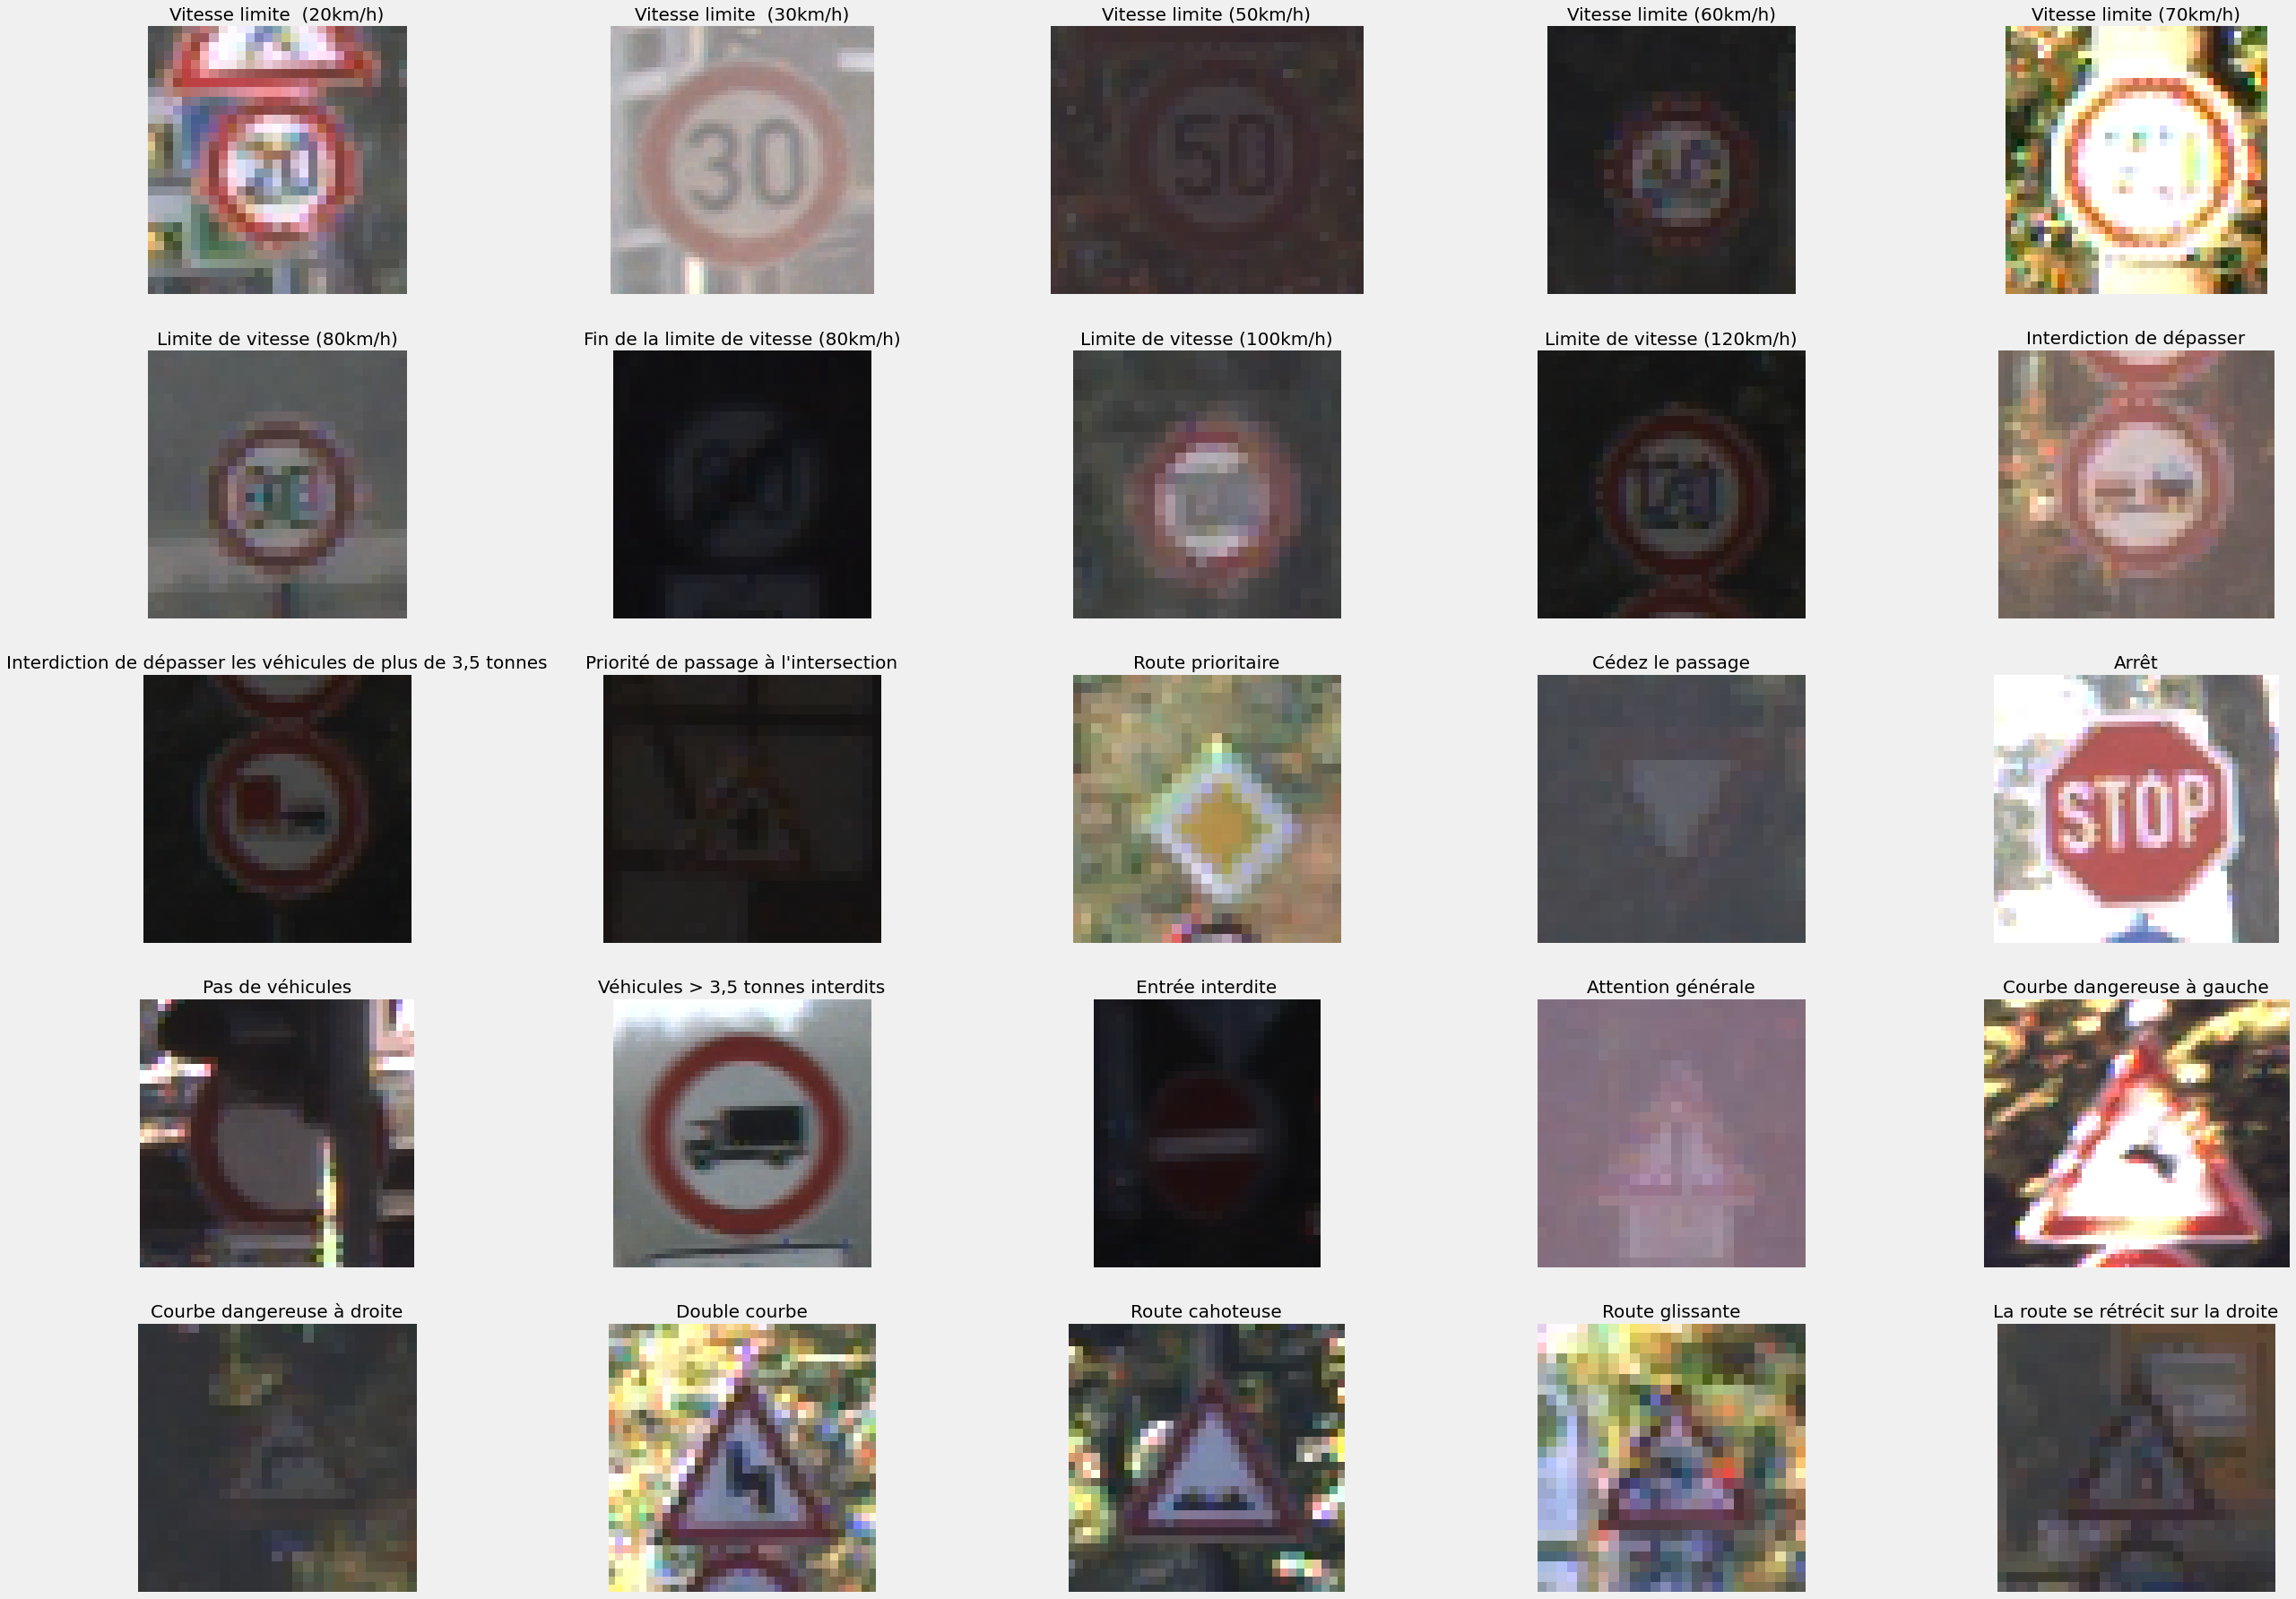

In [21]:
##########affichons quelques images#############
import random
from matplotlib.image import imread

def affichage():
    rows, columns = 5,5
    '''dir_path = "/content/train"''' 
    classes = len(os.listdir(train_path))

    fig, axes = plt.subplots(rows , columns, figsize=(40, 30))
    k = 0
    for row in range(rows):
        for column in range(columns):
            class_path = train_path + '/' + str(k)
            image_path = class_path + '/' + str(os.listdir(class_path)[0])
            ax = axes[row, column]
            ax.set_title(classes_dict[k], loc='center', fontsize=20)
            ax.imshow(imread(image_path))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            k += 1
    plt.show()


folders = os.listdir(train_path)
train_number = []
class_num = []
for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes_dict[int(folder)])
    
zipped_lists = zip(train_number, class_num)
sorted_list = sorted(zipped_lists)
affichage = affichage()

In [22]:
def image_organisation(IMG_HEIGHT,IMG_WIDTH):
    image_data = []
    image_labels = []

    for i in range(NUM_CATEGORIES):
        path = data_dir + '/Train/' + str(i)
        images = os.listdir(path)

        for img in images:
            try:
                image = cv2.imread(path + '/' + img)
                image_fromarray = Image.fromarray(image, 'RGB')
                resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
                image_data.append(np.array(resize_image))
                image_labels.append(i)
            except:
                print("Error in " + img)

    # Changing the list to numpy array
    image_data = np.array(image_data)
    image_labels = np.array(image_labels)

    print(image_data.shape, image_labels.shape)
    
    shuffle_indexes = np.arange(image_data.shape[0])
    np.random.shuffle(shuffle_indexes)
    image_data = image_data[shuffle_indexes]
    image_labels = image_labels[shuffle_indexes]
    return image_data,image_labels


In [23]:
def Partage(image_data,image_labels):
    #image_data = image_data.reshape((image_data.shape[0], IMG_HEIGHT*IMG_WIDTH*channels))
    X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)
    X_train = X_train/255 
    X_val = X_val/255

    print("X_train.shape", X_train.shape)
    print("X_valid.shape", X_val.shape)
    print("y_train.shape", y_train.shape)
    print("y_valid.shape", y_val.shape)
    return  X_train, X_val, y_train, y_val

def repartition(y_train,y_val):
    y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
    y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

    print(y_train.shape)
    print(y_val.shape)
    return y_train, y_val

# implémentation du CNN #######


In [24]:

def model1(IMG_HEIGHT,IMG_WIDTH,channels):
    model = keras.models.Sequential([    
        keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
        keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
        keras.layers.MaxPool2D(pool_size=(2, 2)),
        keras.layers.BatchNormalization(axis=-1),

        keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
        keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
        keras.layers.MaxPool2D(pool_size=(2, 2)),
        keras.layers.BatchNormalization(axis=-1),

        keras.layers.Flatten(),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(rate=0.5),

        keras.layers.Dense(43, activation='softmax')])
    return model

In [90]:
def mode(model,X_train, y_train,X_val,y_val,epochs):
    learning_rate = 0.001
    epochs = epochs
    opt = Adam(learning_rate=learning_rate, decay=learning_rate / (epochs * 0.5))
    #opt = keras.optimizers.SGD(learning_rate=0.01)
        ##ceci represente la descente de gradient
        #precision comme metrique
    model.compile(loss="categorical_crossentropy" ,  optimizer= opt, metrics=["accuracy"])
    aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")
    
    history = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_val, y_val))
    #history = model.fit(X_train, y_train,validation_data= (X_val, y_val), epochs =epochs, verbose =1 )
    return history

def courbe(histori):
    pd.DataFrame(histori.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()
    
    
import seaborn as sns
from sklearn.metrics import confusion_matrix

def prediction(model,IMG_HEIGHT, IMG_WIDTH):
    test = pd.read_csv(data_dir + '/Test.csv')

    labels = test["ClassId"].values
    imgs = test["Path"].values
    print(labels.shape)

    data =[]

    for img in imgs:
        try:
            image = cv2.imread(data_dir + '/' +img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            data.append(np.array(resize_image))
        except:
            print("Error in " + img)
    X_test = np.array(data)
    X_test = X_test/255

    pred = model.predict_classes(X_test)
    print(pred.shape)

    #Accuracy with the test data
    Test_Data_accuracy = print('Test Data accuracy: ',accuracy_score(labels, pred)*100)
    print('/')
    cf = confusion_matrix(labels, pred)
    df_cm = pd.DataFrame(cf, index = classes_dict,  columns = classes_dict)
    plt.figure(figsize = (15,15))
    sns.heatmap(df_cm, annot=True)
    return pred, labels,Test_Data_accuracy,X_test

In [26]:
image_datavgg,image_labelsvgg = image_organisation(IMG_HEIGHT,IMG_WIDTH)
print('/')
print(image_datavgg.dtype)
print(image_labelsvgg.dtype)


#image_datavgg = image_datavgg.astype('float64') 
#image_labelsvgg = image_labelsvgg.astype('float64') 
print('/')
X_trainvgg, X_valvgg, y_trainvgg, y_valvgg  = Partage(image_datavgg,image_labelsvgg)
'''X_trainvgg = X_trainvgg.astype('uint8') 
X_valvgg = X_valvgg.astype('uint8') 
y_trainvgg = y_trainvgg.astype('uint8') 
y_valvgg = y_valvgg.astype('uint8') '''

print(X_trainvgg.dtype)
print(y_trainvgg.dtype)
print('/')
y_trainvgg1,y_valvgg1 = repartition(y_trainvgg,y_valvgg)
'''X_trainvgg = X_trainvgg.astype('uint8') 
X_valvgg = X_valvgg.astype('uint8') 
y_trainvgg1 = y_trainvgg1.astype('uint8') 
y_valvgg1 = y_valvgg1.astype('uint8')''' 
print('/')

(39209, 32, 32, 3) (39209,)
/
uint8
int32
/
X_train.shape (27446, 32, 32, 3)
X_valid.shape (11763, 32, 32, 3)
y_train.shape (27446,)
y_valid.shape (11763,)
float64
int32
/
(27446, 43)
(11763, 43)
/


In [27]:
modele20c =model1(IMG_HEIGHT,IMG_WIDTH,channels)

In [28]:
nombre_iteration = 5
mode11 = mode(modele20c ,X_trainvgg,y_trainvgg1, X_valvgg, y_valvgg1 ,nombre_iteration)

Epoch 1/5
858/858 [==============================] - 34s 40ms/step - loss: 0.9355 - accuracy: 0.7496 - val_loss: 0.0412 - val_accuracy: 0.9879
Epoch 2/5
858/858 [==============================] - 35s 41ms/step - loss: 0.1300 - accuracy: 0.9616 - val_loss: 0.0206 - val_accuracy: 0.9946
Epoch 3/5
858/858 [==============================] - 36s 42ms/step - loss: 0.0659 - accuracy: 0.9810 - val_loss: 0.0152 - val_accuracy: 0.9963
Epoch 4/5
858/858 [==============================] - 38s 44ms/step - loss: 0.0528 - accuracy: 0.9845 - val_loss: 0.0118 - val_accuracy: 0.9960
Epoch 5/5
858/858 [==============================] - 37s 43ms/step - loss: 0.0375 - accuracy: 0.9897 - val_loss: 0.0075 - val_accuracy: 0.9974


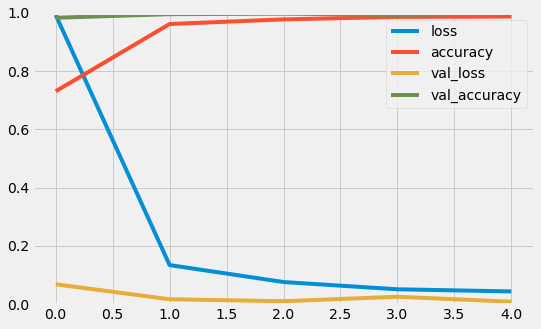

In [22]:
courbevgg =courbe(mode11) 

(12630,)
(12630,)
Test Data accuracy:  97.71971496437054
/


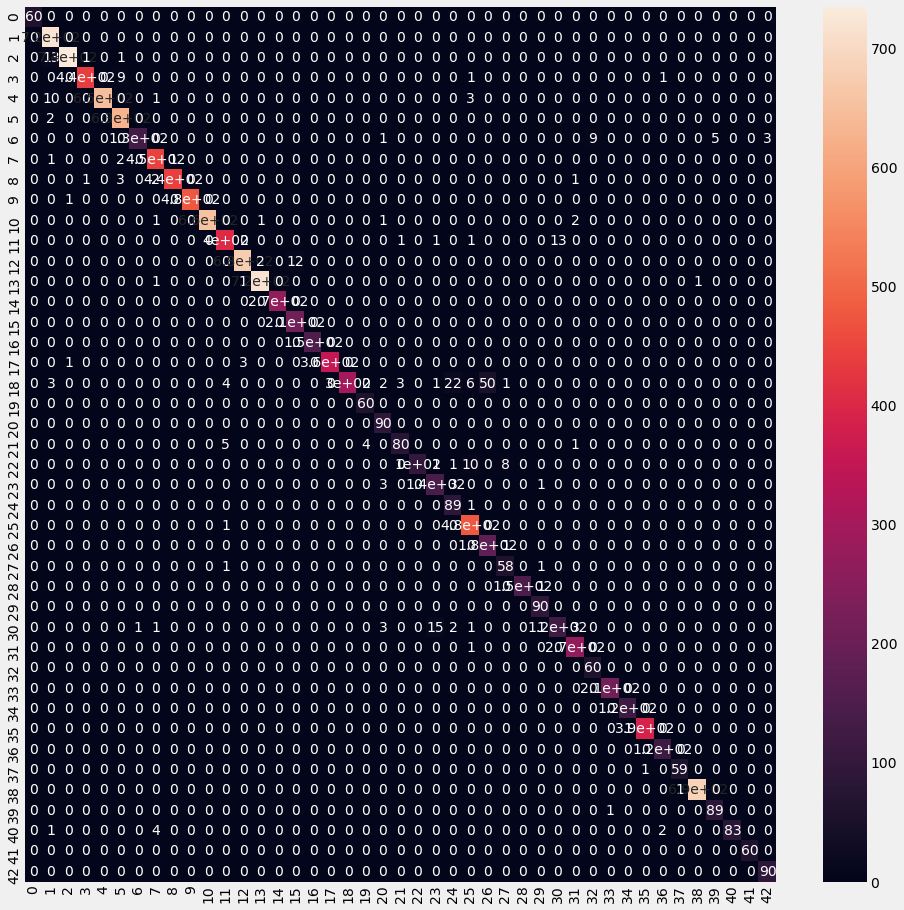

In [91]:
pred, labels,Test_Data_accuracy,X_test = prediction (modele20c ,IMG_HEIGHT,IMG_WIDTH)

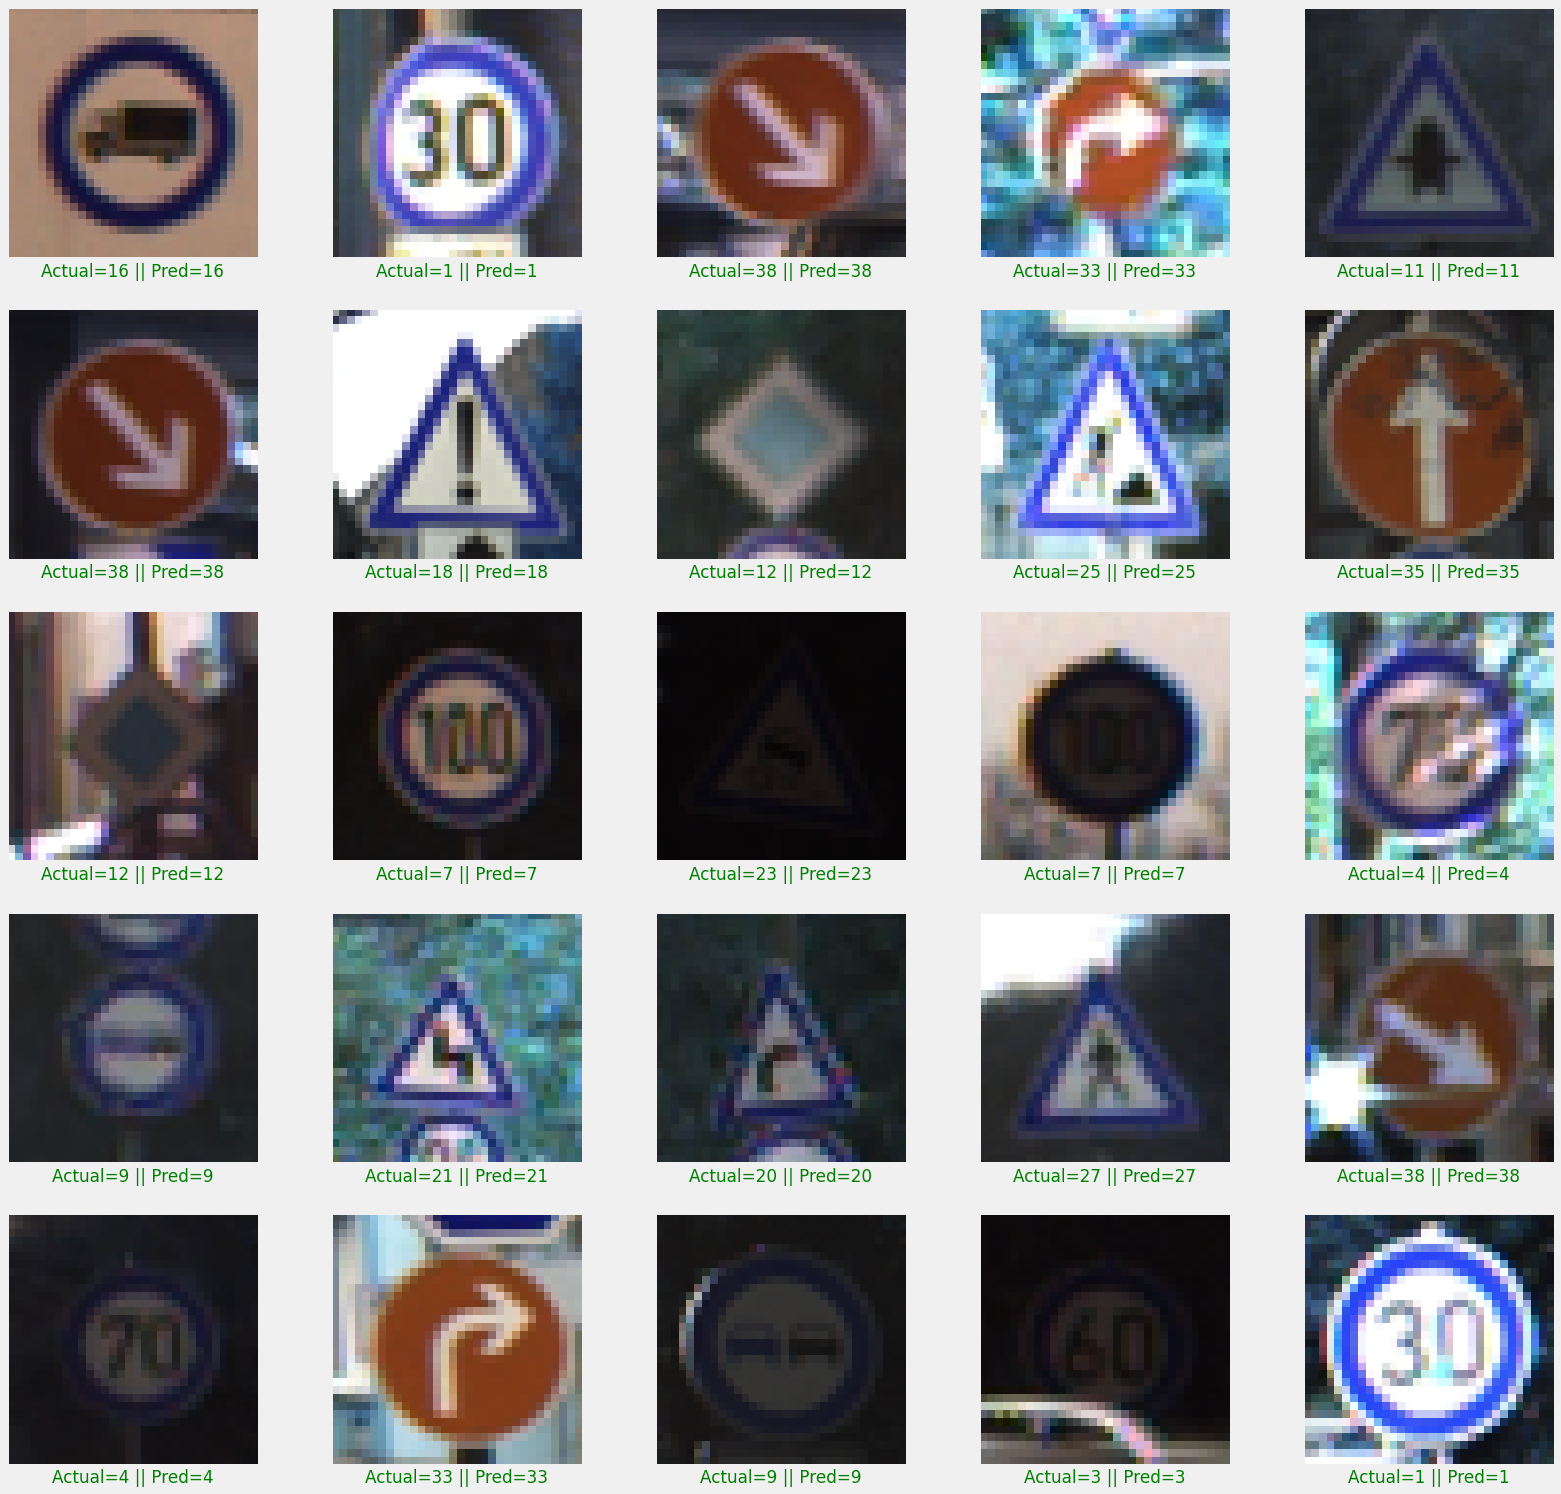

In [93]:
def affiche_pred(pred ,labels):
    plt.figure(figsize = (25, 25))
    
    start_index = 0
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        prediction = pred[start_index + i]
        actual = labels[start_index + i]
        col = 'g'
        if prediction != actual:
            col = 'r'
        plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
        plt.imshow(X_test[start_index + i])
    plt.show()
affiche_pred(pred,labels)

# implementation des differentes attaques et defense

### defense 

#### Autoencoder

In [39]:
def att():
    # Detector and Reformer model for CIFAR-10
    #def Autoencoder(input_img):
    #input = 28 x 28 x 1 (wide and thin)
    input_img = keras.Input(shape=(IMG_HEIGHT,IMG_WIDTH, channels))
    
    image_shape=(IMG_HEIGHT,IMG_WIDTH, channels)
    input = tf.keras.Input(shape=image_shape)
    x = tf.keras.layers.Conv2D(3,3,padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(input)
    x = tf.keras.layers.Activation("sigmoid")(x)
    x = tf.keras.layers.Conv2D(3,3,padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
    x = tf.keras.layers.Activation("sigmoid")(x)
    x = tf.keras.layers.Conv2D(image_shape[-1],3,padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)
    x = tf.keras.layers.Activation("sigmoid")(x)

    model_detector = tf.keras.Model(inputs=input, outputs=x)
    model_reformer = tf.keras.Model(inputs=input, outputs=x)

    model_detector.summary()

    model_detector.compile(optimizer='adam',loss = 'mean_squared_error', metrics='accuracy')
    model_reformer.compile(optimizer='adam',loss = 'mae', metrics='accuracy')
    return model_detector,model_reformer
#model_detector=att(56,56, 3)
model_detector,model_reformer=att()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 3)         84        
_________________________________________________________________
activation (Activation)      (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 3)         84        
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 3)         84        
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 3)        

In [40]:
def entrainement_autoencodeur(x_adversarial_train,X_trainvgg,x_adversarial_test, X_valvgg,model_detector,model_reformer):
    
    epochs=10
    #print(x_test_patch.shape, X_trainvgg.shape)
    #print(y_test_patch.shape, X_valvgg.shape)
    #mode11 = mode(autoencodeur,x_test_patch,X_trainvgg, X_valvgg, y_valvgg1 )
   
    model_detector.fit(x_adversarial_train,X_trainvgg,
                epochs=epochs,
                batch_size=256,
                shuffle=True,
                validation_data=(x_adversarial_test, X_valvgg))

    model_reformer.fit(x_adversarial_train,X_trainvgg,
                epochs=epochs,
                batch_size=256,
                shuffle=True,
                validation_data=(x_adversarial_test, X_valvgg))
    return model_detector

In [41]:
def hstackimgs(min, max, images):
    return np.hstack(images[i] for i in range(min, max))

def sqstackimgs(length, height, images):
    return np.vstack(hstackimgs(i*length, (i+1)*length, images) for i in range(height))

def sbscompare(images1, images2, length, height):
    A = sqstackimgs(length, height, images1)
    B = sqstackimgs(length, height, images2)
    C = np.ones((A.shape[0], 32, 3))
    return np.hstack((A, C, B))

In [76]:
def prediction_autoencodeur(x_adversarial_test,model_detector):
    x_test = x_adversarial_test
    #noise = np.random.normal(0, NOISE, x_test.shape)
    pred_imgs = model_detector.predict(x_test)

    plt.imshow(sbscompare(x_test, pred_imgs, 5, 5))
    plt.axis('off')
    plt.rcParams["figure.figsize"] = [60,60]
    plt.show()
    return pred_imgs

In [81]:
def printresultat(resultat_random):
    plt.figure(figsize = (25, 25))
    test = pd.read_csv(data_dir + '/Test.csv')

    labels = test["ClassId"].values
    pred = modele20c.predict_classes(resultat_random)
    print('Test Data accuracy: ',accuracy_score(y_valvgg, pred)*100)
    start_index = 0
    for i in range(25):
            plt.subplot(5, 5, i + 1)
            plt.grid(False)
            plt.xticks([])
            plt.yticks([])
            prediction = pred[start_index + i]
            actual = y_valvgg[start_index + i]
            col = 'g'
            if prediction != actual:
                col = 'r'
            plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
            plt.imshow(X_valvgg[start_index + i])
    plt.show()

In [48]:
'''def affiche_autoencoder(x_adversarial_test,model_20):
    #model_20.save_weights( 'modele50itertaille32.h5')
    #model_20.evaluate(y_test_patch, X_valvgg)
    #print(y_pred_class1)
    num_imgs = 16
    rand = np.random.randint(1, 100)

    test_images = x_adversarial_test[rand:rand+num_imgs] # slicing
    test_desoided = model_20.predict(X_valvgg) # predict

    # Select few random test images
    '''
    ''''num_imgs = 16
    rand = np.random.randint(1, 100)

    test_images = test_noise[rand:rand+num_imgs] # slicing
    test_desoided = autoencoder.predict(test_images) # predict'''
    ''''rows = 2 # defining no. of rows in figure
    cols = 8 # defining no. of colums in figure

    f = plt.figure(figsize=(2*cols,2*rows*2)) # defining a figure 

    for i in range(rows):
        for j in range(cols): 
            f.add_subplot(rows*2,cols, (2*i*cols)+(j+1)) # adding sub plot to figure on each iteration
            plt.imshow(test_images[i*cols + j],cmap="Reds") 
            plt.axis("off")

        for j in range(cols): 
            f.add_subplot(rows*2,cols,((2*i+1)*cols)+(j+1)) # adding sub plot to figure on each iteration
            plt.imshow(test_desoided[i*cols + j],cmap="Reds") 
            plt.axis("off")

    f.suptitle("Autoencoder Results",fontsize=18)
    plt.savefig("test_results.png")

    plt.show()
'''

#### KNN classifiacation par les plus proches voisins

In [35]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

from sklearn.model_selection import  GridSearchCV

In [36]:
#####trasformation au bonne dimmensions pour lusage du  KNN
def transformation_knn(X_trainvgg,y_trainvgg1):
    from sklearn.neighbors import KNeighborsClassifier
    data = np.array(X_trainvgg)
    #data = data.astype(float)/255
    data = data.reshape((data.shape[0], IMG_HEIGHT*IMG_WIDTH*channels))
    data_scaled = data.astype(float)/255
    labelsknn = np.array(y_trainvgg1)

    from sklearn.preprocessing import LabelEncoder
    '''le = LabelEncoder()
    labels = le.fit_transform(labelsknn)'''


    #datatest2 = datatest.astype(float)/255
    return data , labelsknn

In [37]:
def knn_prediction(x_valknn , yvalknn,x_valknntest,yvalknntest):
    #x_valknntest: donne test
    model = KNeighborsClassifier()
    model.fit(x_valknn , yvalknn )
    #print(model.score(x_valknn , yvalknn) )
    y_pred = model.predict(x_valknntest)
    print(metrics.accuracy_score(y_pred, yvalknntest))
    return y_pred, model

In [38]:
def verificatio_pred(pred,y_valvgg1,chiffre):
    
    for i in range(chiffre):
        
        print('original: ',(y_valvgg1[i]), ' predicted: ',
            np.argmax(pred[i]), 'nom pannaux: ', classes_dict[y_valvgg1[i]])
        #pred = np.argmax(pred)


#### Entrainement contradictoire

### adversarial pacht_attack

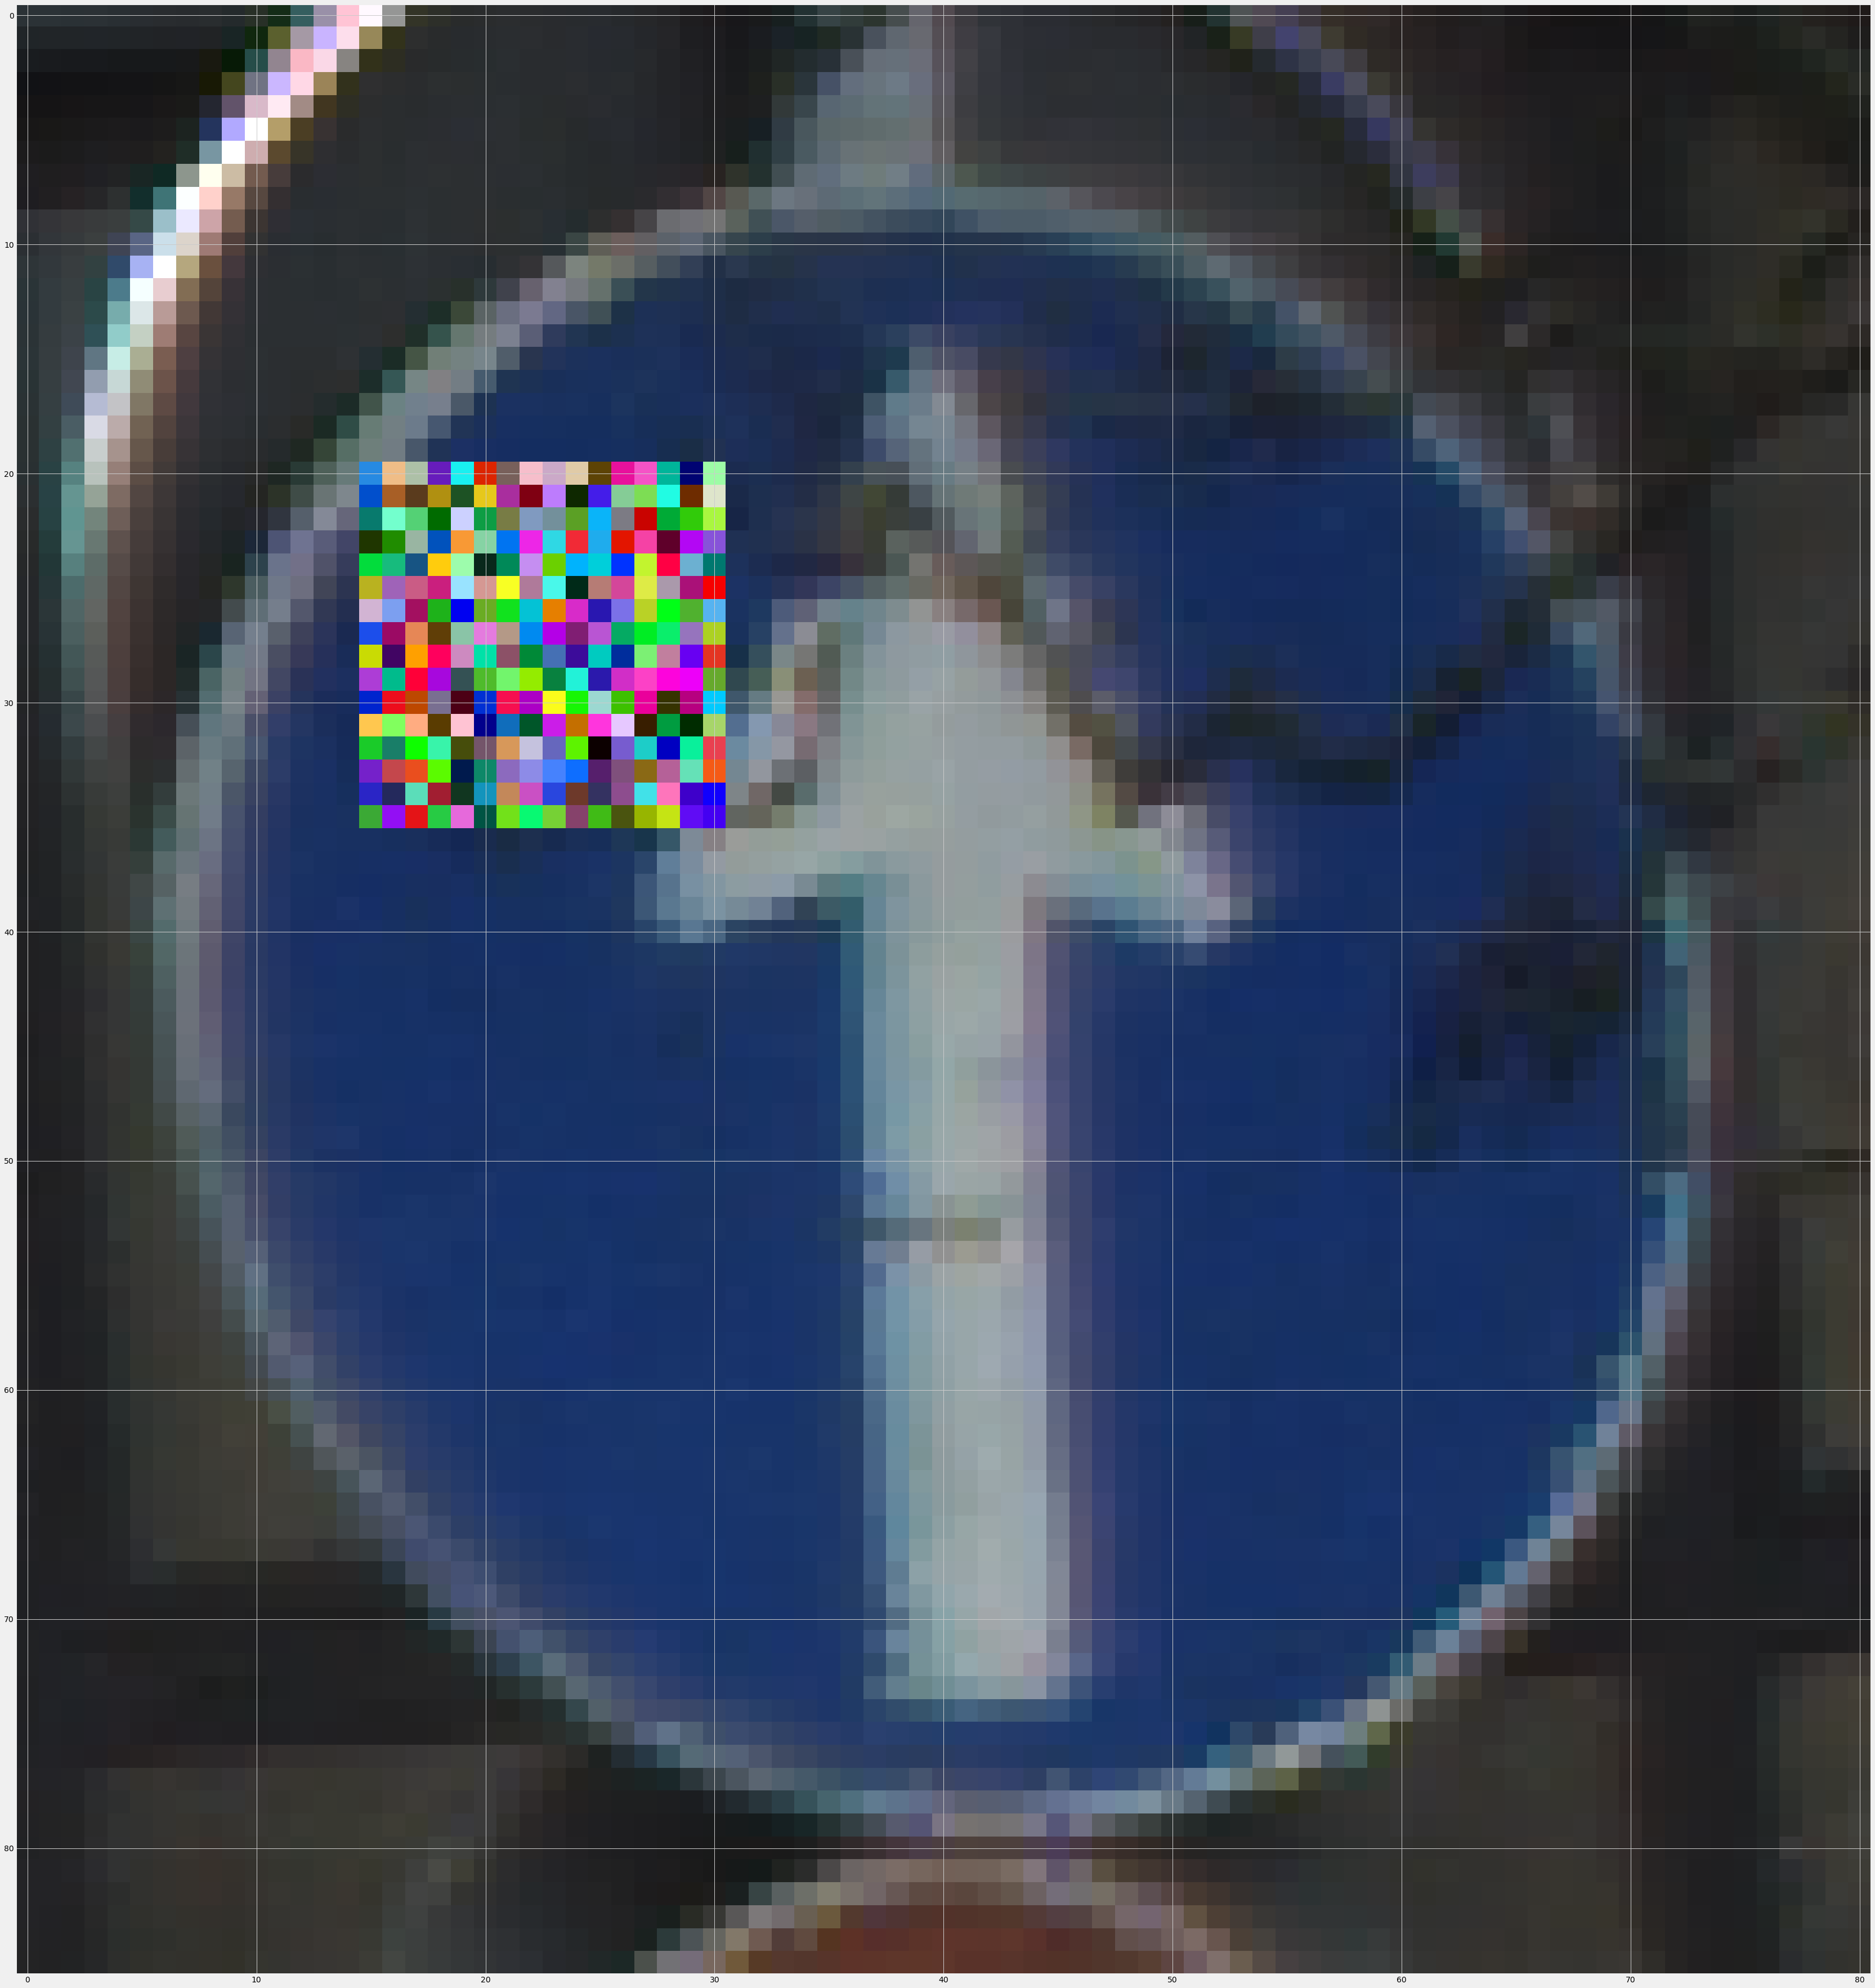

In [101]:
import numpy as np 
import cv2

def patch_attack(original_img,patch,resize=False):
    """
    Patch performs an advserial patch black box attack on a neural network
    """
    #print("Initial shape:", original_img.shape) # (2308,3468,3) GIBBON
        # (1026,778,3) TOTORO
    #print((original_img.shape))
    #print(original_img.shape[:2])
    h, w = original_img.shape[:2]
    size = min(h,w)
    size //= 5
   # print(size)

    patch = cv2.resize(patch, dsize=(size, size), interpolation=cv2.INTER_CUBIC)
    #print("SIZES", patch.shape) # (662,838,4)

    x_offset = w - size - 50
    x_offset = abs(x_offset)
    #print('x_offset')
    #print(x_offset)
    y_offset = h - size - 50
    #print(y_offset)
    y_offset = abs(y_offset)

    y1, y2 = y_offset, y_offset + patch.shape[0]
    #print("y1, y2", y1, y2) #(50,712) # diff: 155
    x1, x2 = x_offset, x_offset + patch.shape[1]
    #print("x1, x2", x1, x2) #(50,888) # diff: 155

    assert patch.shape[2] == 4, "Make sure you use cv2.imread('patch.png',-1)"
    # alpha_s is a one-hot vector
    alpha_s = patch[:, :, 3] / 255.0
    #print(f"alpha_s:{alpha_s}")
    alpha_l = 1.0 - alpha_s
    #print(f"alpha_l:{alpha_l}")

    #print(original_img.shape)  #(1026,778,3)
    #print("A", patch[:,:,:].shape)  #(662, 838, 4)
    #print("B", original_img[y1:y2, x1:x2, :].shape)  #(662, 728, 3)

    for c in range(0, 3):
        original_img[y1:y2, x1:x2, c] = (alpha_s * patch[:, :, c] + alpha_l * original_img[y1:y2, x1:x2, c])

    # if resize != False : original_img = cv2.resize(original_img, resize)
    # x_pos = original_img[::-1].astype(np.float32)
    #print("Final shape:", original_img.shape)
    
    
    for c in range(0, 3):
        original_img[y1:y2, x1:x2, c] = (alpha_s * patch[:, :, c] + alpha_l * original_img[y1:y2, x1:x2, c])

    # if resize != False : original_img = cv2.resize(original_img, resize)
    # x_pos = original_img[::-1].astype(np.float32)
    #print("Final shape:", original_img.shape)
    return original_img




original_imgpp = cv2.imread('../OneDrive\Bureau\projetnakib\Test/00009.png')
original_imgpp = cv2.cvtColor(original_imgpp, cv2.COLOR_BGR2RGB)
#print(original_img.shape)
patch = cv2.imread('../OneDrive\Bureau\projetnakib\patch\patch_attack.png',-1)
x_pos = patch_attack(original_imgpp,patch)
plt.imshow(x_pos)



In [102]:
def generate_patch_attaque_imaget(x):
    adversed_images=[]
    patch = cv2.imread('../OneDrive\Bureau\projetnakib\patch\patch_attack.png',-1)

    for i in range (x.shape[0]):

      patched_image=patch_attack(x[i],patch)

      adversed_images.append(patched_image)

    x_test = np.array(adversed_images)

    x_test1 = x_test / 255
    return x_test,x_test1

In [103]:
x_valpatch = X_valvgg
X_trainvggpatch = X_trainvgg

In [104]:
x_test_patch,x_test_patch1  =generate_patch_attaque_imaget(x_valpatch)
x_train_patch,x_train_patch1  =generate_patch_attaque_imaget(X_trainvggpatch)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

(11763,)
Test Data accuracy:  3.1539573238119525


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

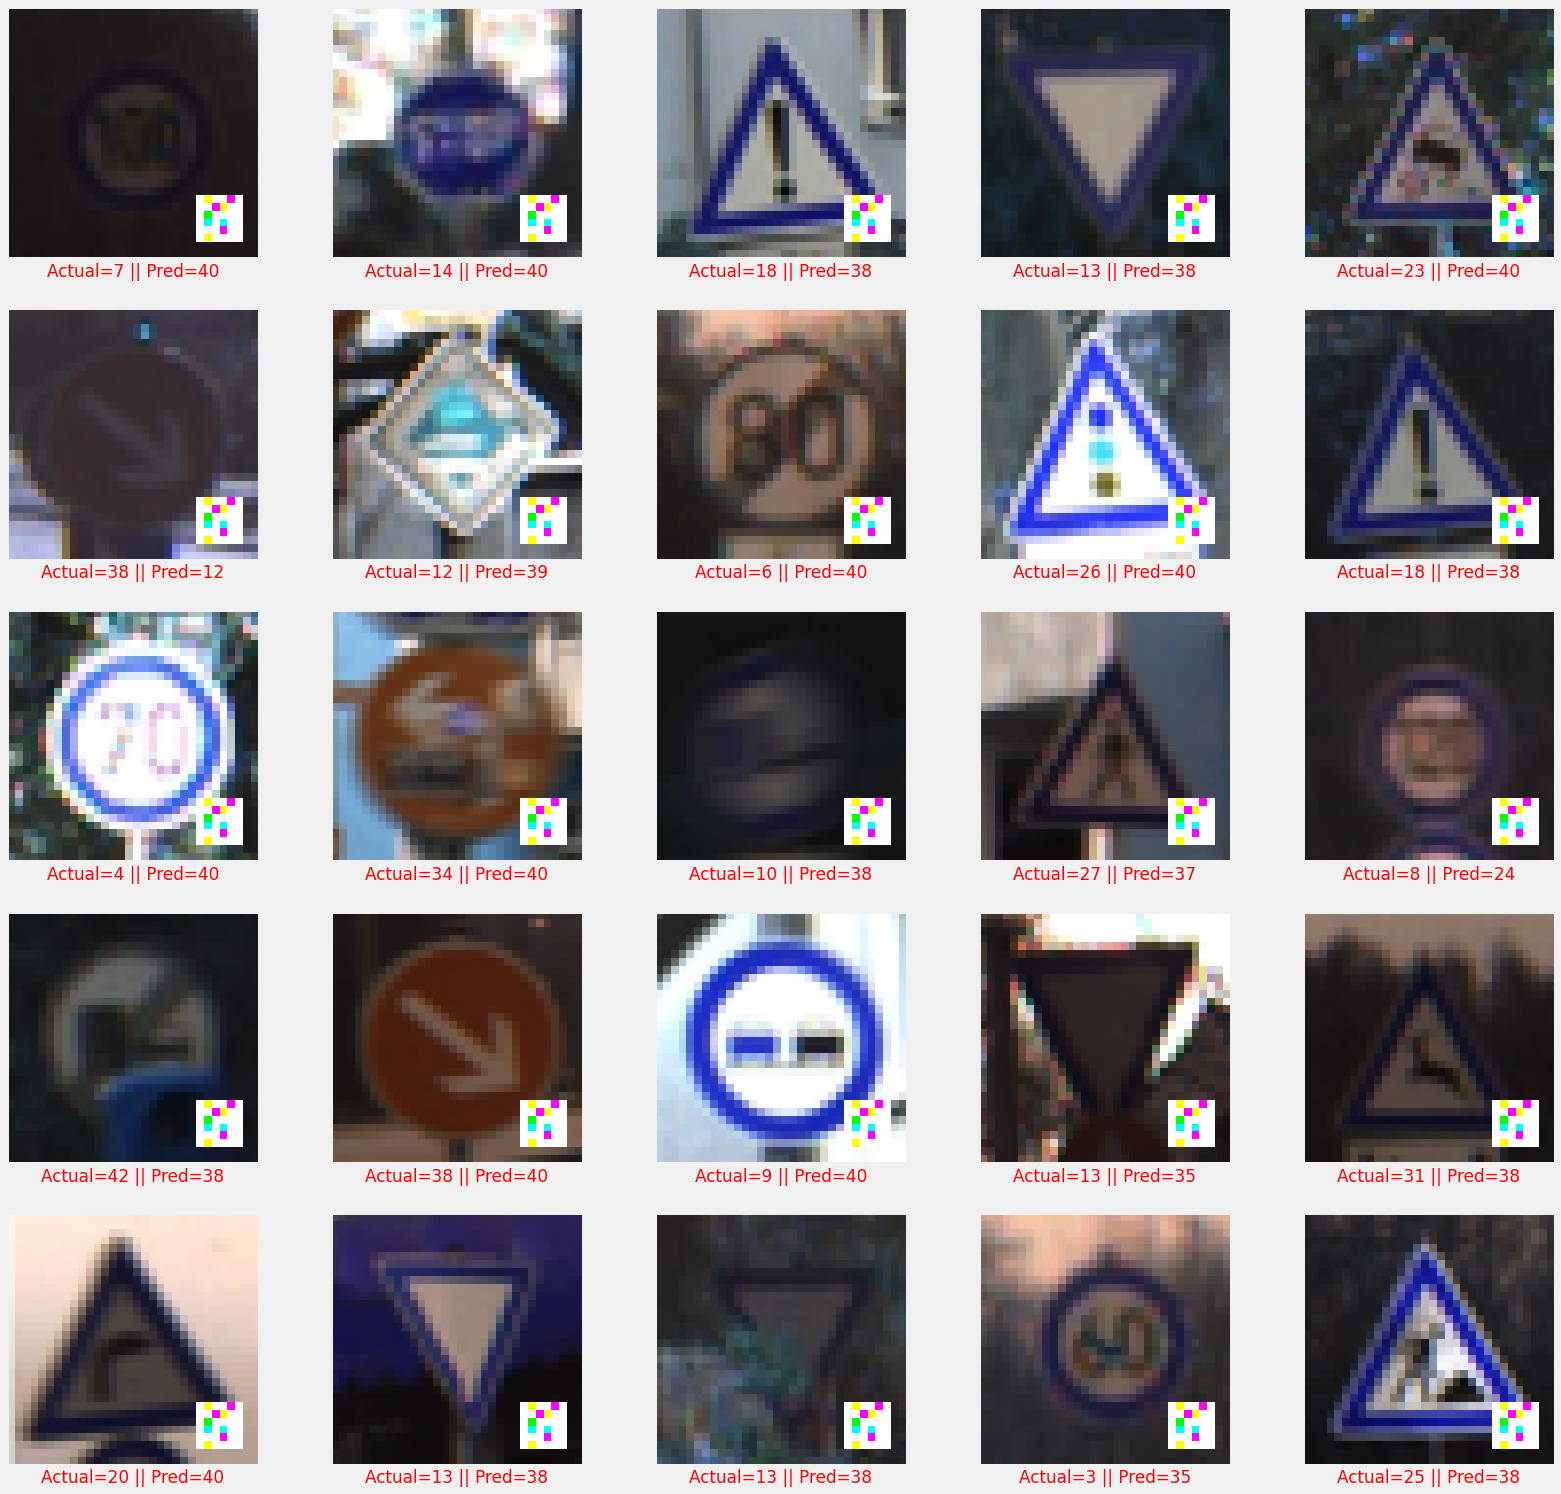

In [105]:
def accuracy_patch_attack(y_test_patch,pred = None):
    test = pd.read_csv(data_dir + '/Test.csv')

    labels = test["ClassId"].values
    imgs = test["Path"].values

    data =[]

    for image in y_test_patch:
        try:

            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            data.append(np.array(resize_image))
        except:
            print("Error in " + img)
    X_test = np.array(data)
    X_test1 = X_test/255
    if pred == None:
        pred = modele20c.predict_classes(X_test)
    print(pred.shape)
    print('Test Data accuracy: ',accuracy_score(y_valvgg, pred)*100)
    plt.figure(figsize = (25, 25))

    start_index = 0
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        prediction = pred[start_index + i]
        actual = y_valvgg[start_index + i]
        col = 'g'
        if prediction != actual:
            col = 'r'
        plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
        plt.imshow(X_valvgg[start_index + i])
    plt.show()
accuracy_patch_attack(x_test_patch)

##### entrainement contradictoire

Epoch 1/10
858/858 [==============================] - 35s 41ms/step - loss: 2.5014 - accuracy: 0.3325 - val_loss: 1.0311 - val_accuracy: 0.6919
Epoch 2/10
858/858 [==============================] - 35s 41ms/step - loss: 0.6543 - accuracy: 0.7951 - val_loss: 0.1334 - val_accuracy: 0.9660
Epoch 3/10
858/858 [==============================] - 35s 41ms/step - loss: 0.2828 - accuracy: 0.9146 - val_loss: 0.0830 - val_accuracy: 0.9755
Epoch 4/10
858/858 [==============================] - 35s 41ms/step - loss: 0.1724 - accuracy: 0.9471 - val_loss: 0.0291 - val_accuracy: 0.9923
Epoch 5/10
858/858 [==============================] - 38s 44ms/step - loss: 0.1319 - accuracy: 0.9598 - val_loss: 0.0411 - val_accuracy: 0.9876
Epoch 6/10
858/858 [==============================] - 37s 43ms/step - loss: 0.0974 - accuracy: 0.9702 - val_loss: 0.0297 - val_accuracy: 0.9922
Epoch 7/10
858/858 [==============================] - 37s 43ms/step - loss: 0.0805 - accuracy: 0.9753 - val_loss: 0.0312 - val_accuracy:

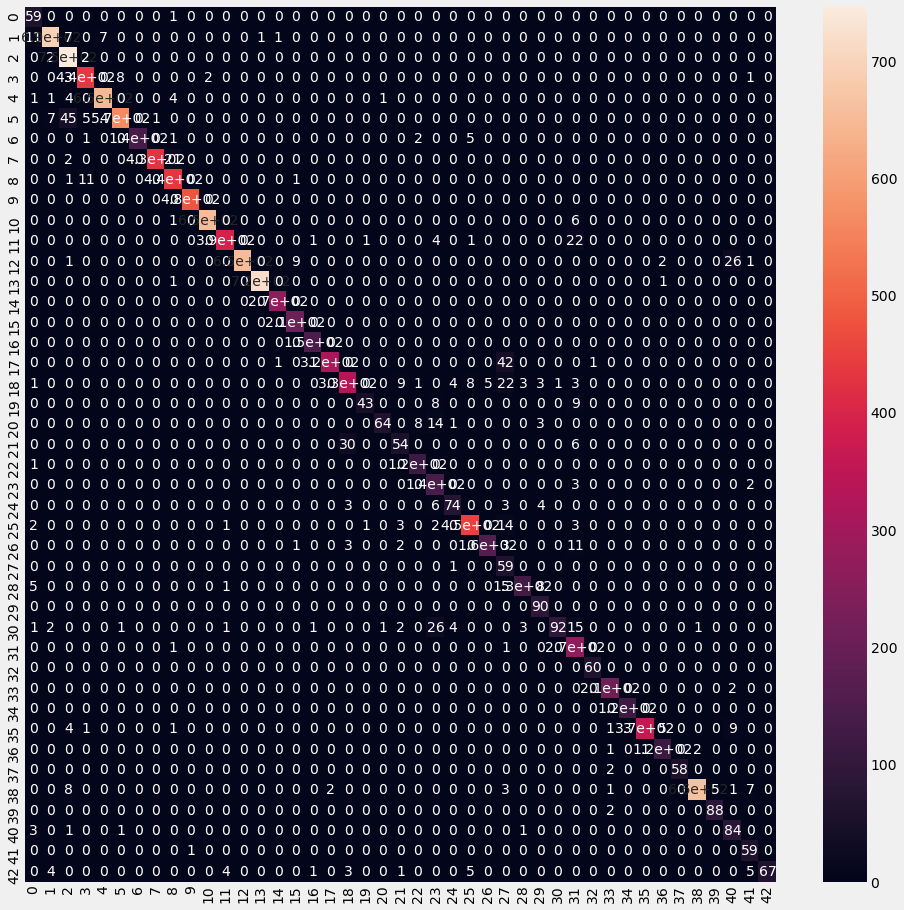

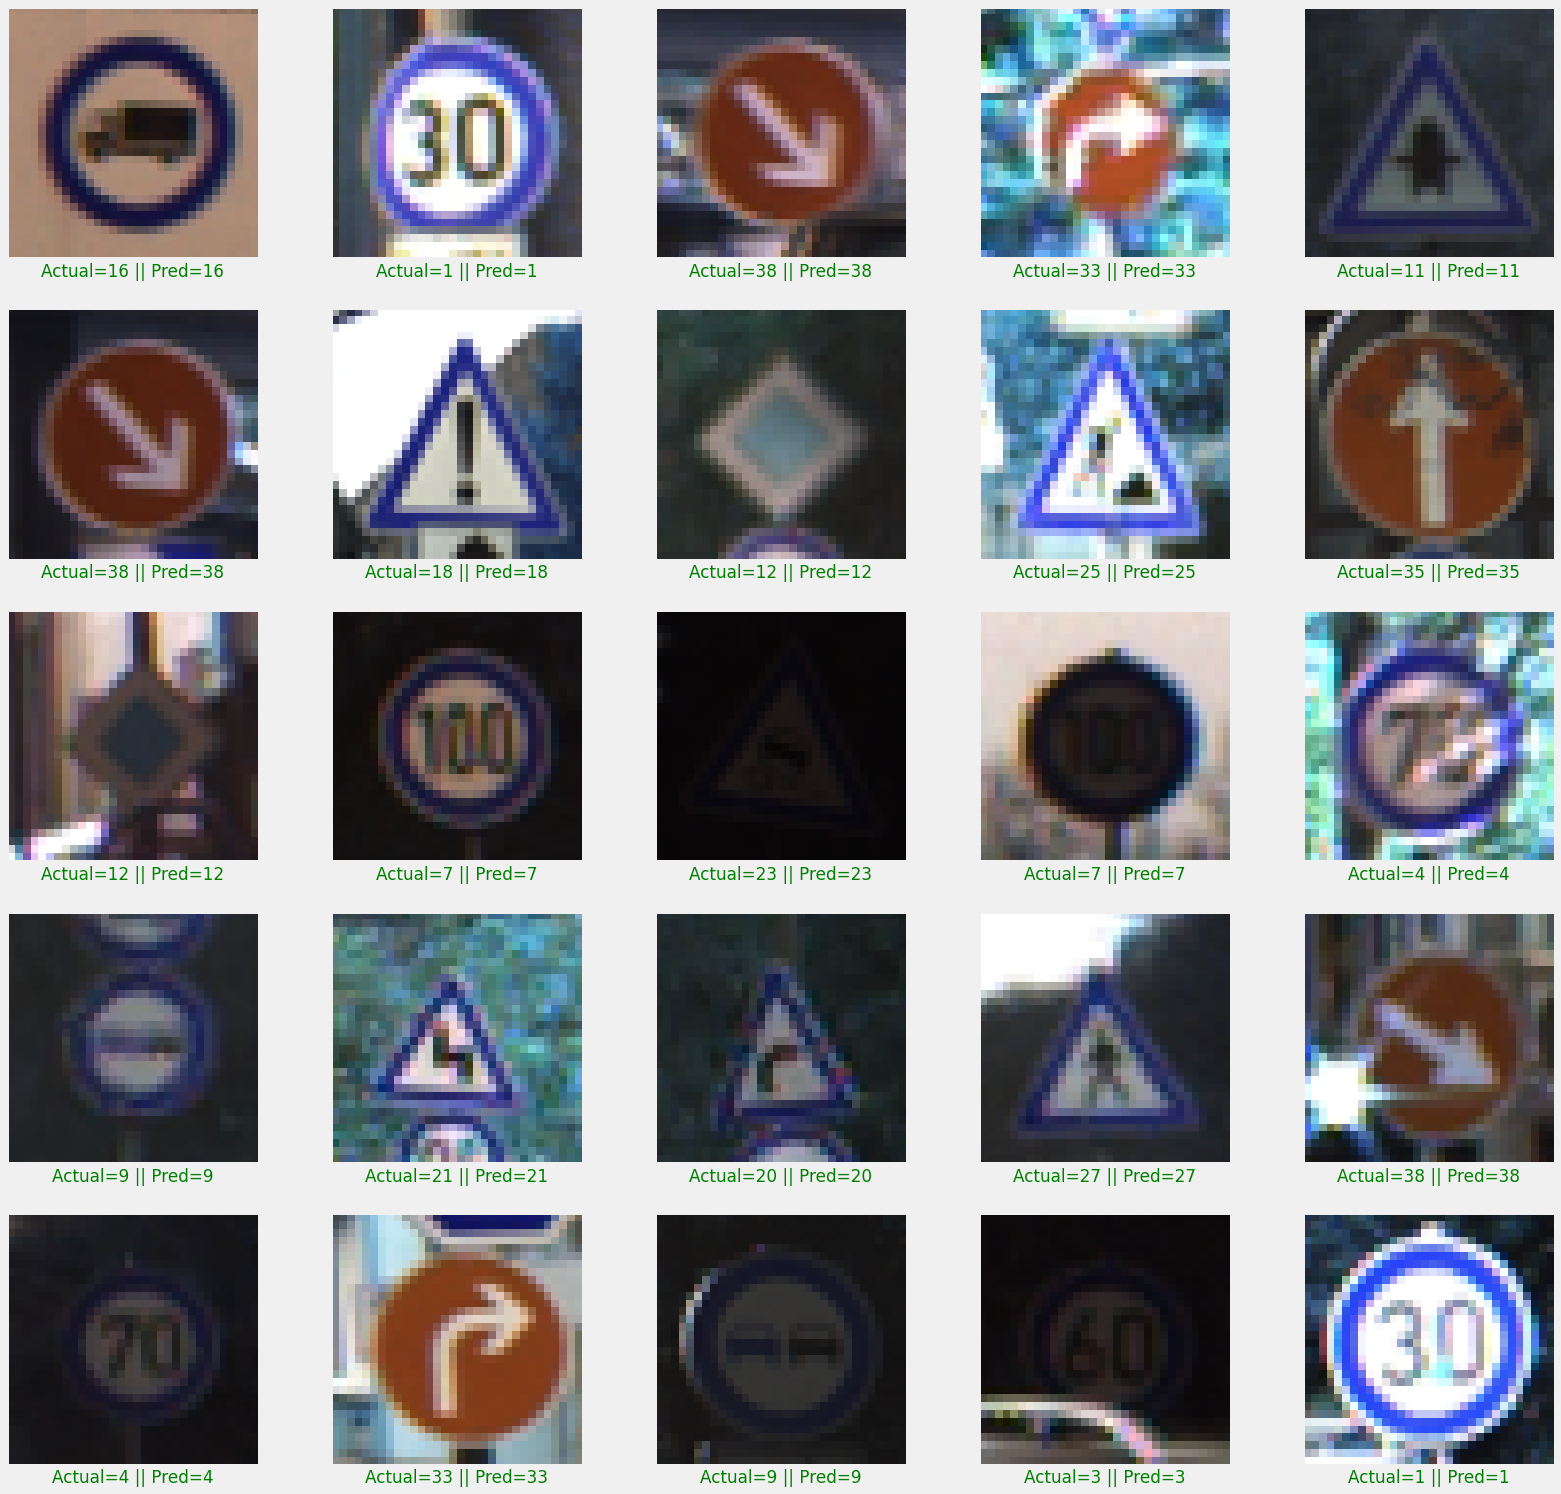

In [106]:
#entrainement contradictoire
modele20patch =model1(IMG_HEIGHT , IMG_WIDTH, channels)
nombre_iteration = 10

mode11patch = mode(modele20patch ,x_train_patch,y_trainvgg1, x_test_patch,y_valvgg1,
nombre_iteration)
pred_patch, labels_patch,Test_Data_accuracy_patch,X_test_patch = prediction (modele20patch 
                                                        ,IMG_HEIGHT , IMG_WIDTH)
affiche_pred(pred_patch,labels_patch)

##### Autoencoder  sur PATCH attack 

In [ ]:
model_detector_patch,model_reformer_patch=att()
entrainement_autoencodeur(x_train_patch,X_trainvgg,x_test_patch, X_valvgg,
                          model_detector_patch,model_reformer_patch)

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 32, 32, 3)         84        
_________________________________________________________________
activation_12 (Activation)   (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 32, 32, 3)         84        
_________________________________________________________________
activation_13 (Activation)   (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 32, 32, 3)         84        
_________________________________________________________________
activation_14 (Activation)   (None, 32, 32, 3)       

<ipython-input-46-22d7e6623248>:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.vstack(hstackimgs(i*length, (i+1)*length, images) for i in range(height))
<ipython-input-46-22d7e6623248>:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.hstack(images[i] for i in range(min, max))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


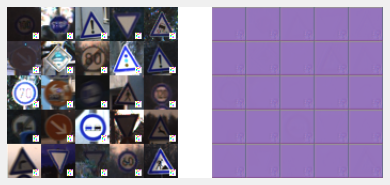

In [49]:
#affiche_autoencoder(x_test_patch,model_20_autoencodeur_patch)
resutat_patch = prediction_autoencodeur(x_test_patch,model_detector)

(11763,)
Test Data accuracy:  1.793760095213806


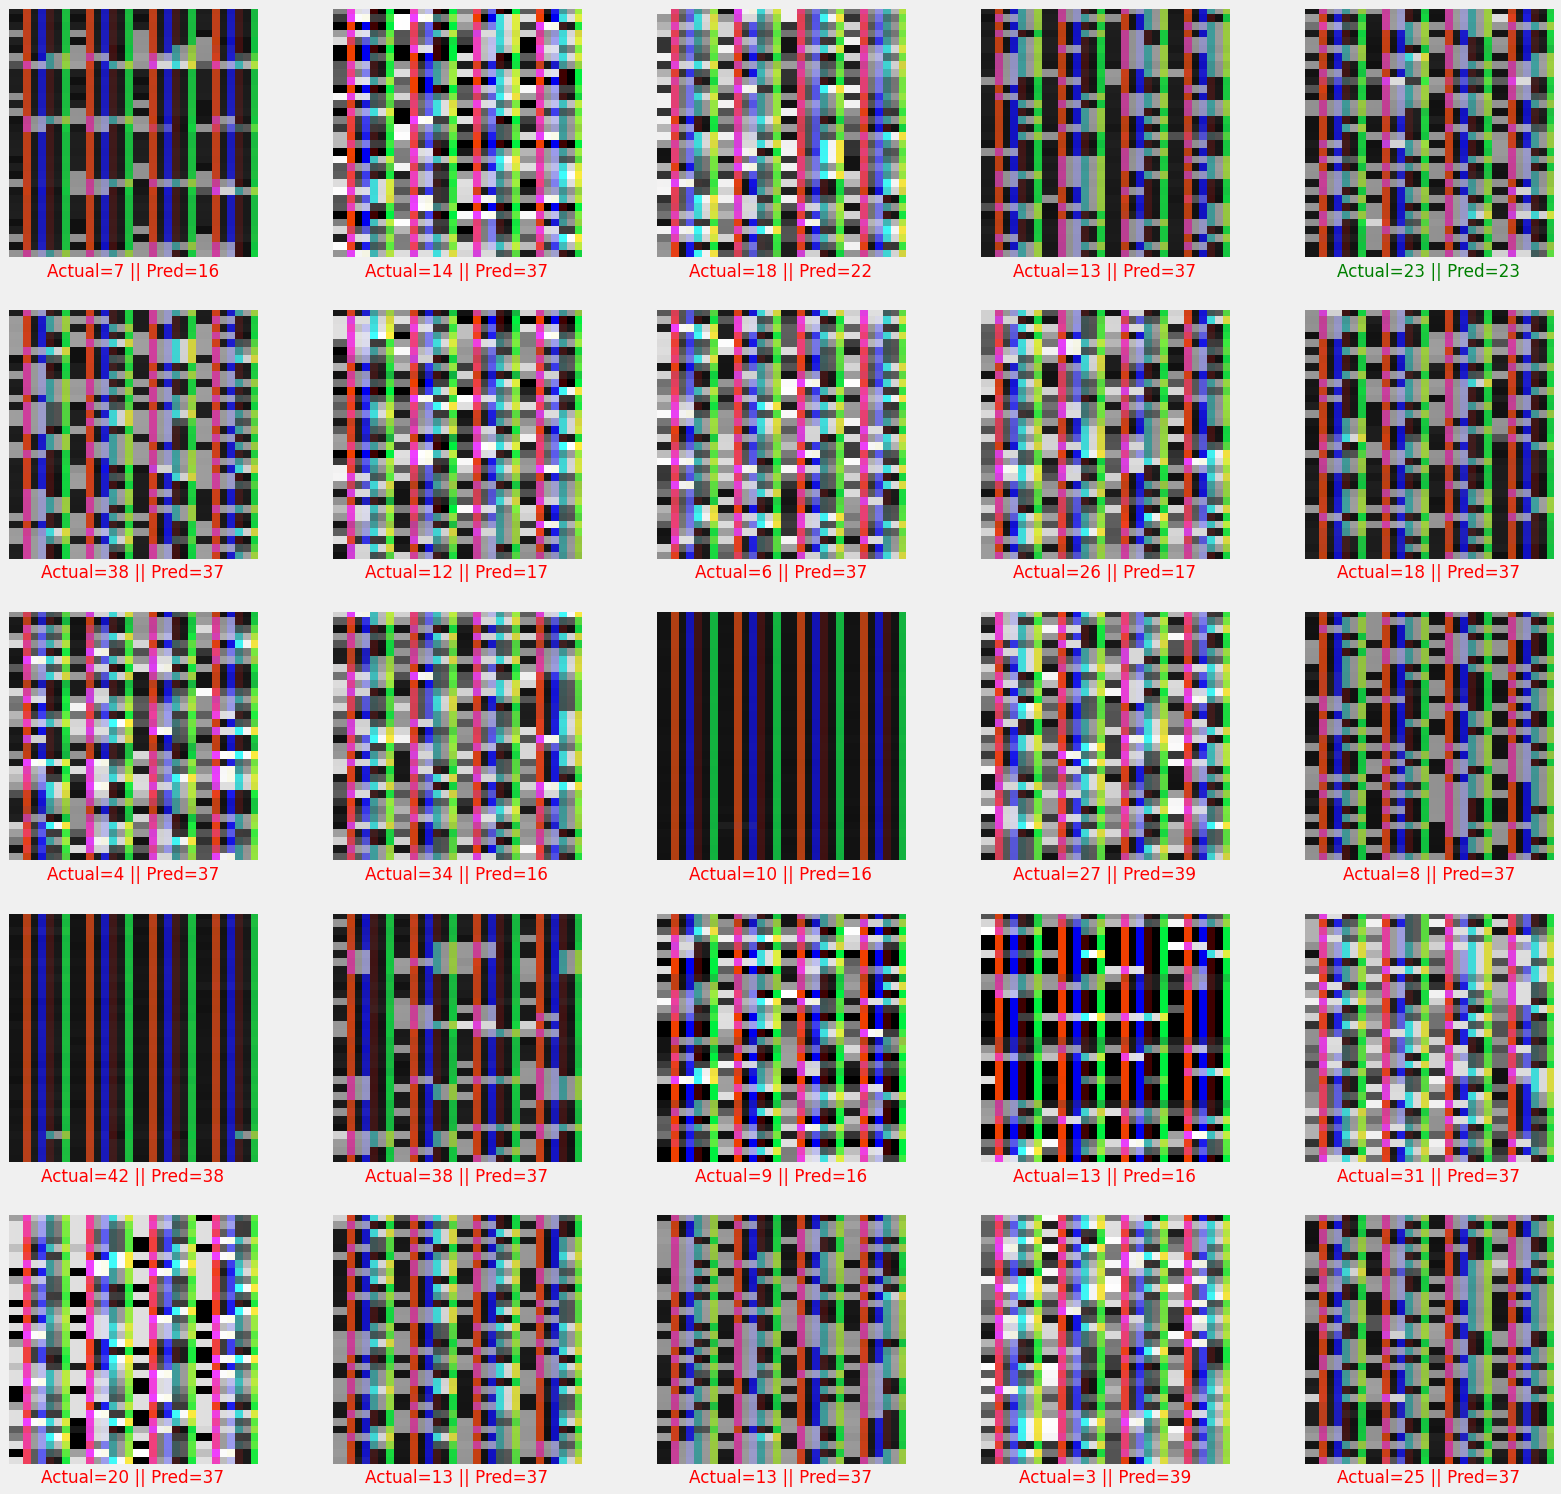

In [50]:
printresultat(resutat_patch)

##### KNN sur PActh

In [122]:
'''x_train_patchknn, y_train_patchknn = transformation_knn(x_train_patch,
                                                                    y_trainvgg)

x_test_patchknn, y_test_patchknn = transformation_knn(x_test_patch,
                                                                    y_valvgg)'''

In [139]:
'''y_pred_knn_PActh, model_PActh = knn_prediction(x_train_patchknn, y_train_patchknn,
                                 x_test_patchknn, y_test_patchknn)'''

0.8602397347615405


In [96]:
'''chiffre = 5
#print(classification_report(y_adversarial_test,y_valvgg, y_pred_knn_fgsm))
#verificatio_pred(y_valvgg1,y_valvgg1,chiffre)
accuracy_patch_attack(x_test_patchknn,y_pred_knn_PActh)'''

'chiffre = 5\n#print(classification_report(y_adversarial_test,y_valvgg, y_pred_knn_fgsm))\n#verificatio_pred(y_valvgg1,y_valvgg1,chiffre)\naccuracy_patch_attack(x_test_patchknn,y_pred_knn_PActh)'

#### FGSM ATTACK

In [29]:
# Adversary noise
test = pd.read_csv(data_dir + '/Test.csv')
labels = test["ClassId"].values
labels = labels.astype('uint8')


def generate_adversary(image, label):
  image = tf.cast(image, tf.float32)

  with tf.GradientTape() as tape:
    tape.watch(image)
    prediction = modele20c(image)
    loss = tf.keras.losses.MSE(label, prediction)
  gradient = tape.gradient(loss, image)
  sign_grad = tf.sign(gradient)
    
  return sign_grad

In [30]:
#X_trainvgg, y_trainvgg14
def affiche_fgsm(X_trainvgg1,y_trainvgg1):
#X_trainvgg1 = X_trainvgg.reshape((-1, IMG_HEIGHT, IMG_WIDTH, channels))
    IMG_HEIGHT = 32
    IMG_WIDTH = 32
    channels = 3
    rand_idx = np.random.randint(0,len(X_valvgg))
    print(rand_idx)
    image = X_trainvgg1[rand_idx].reshape((1, IMG_HEIGHT, IMG_WIDTH, channels))
    label = y_trainvgg1[rand_idx]

    print(f'Prediction from CNN:{classes_dict[np.where(label==1)[0][0]]}')
    plt.figure(figsize=(3,3))
    plt.imshow(image.reshape((IMG_HEIGHT, IMG_WIDTH, channels)))
    plt.show()
    
    print('ajout des perturbations')
    perturbations = generate_adversary(image,label).numpy()
    adversarial = image + (perturbations * 0.05)
    fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True)
    ax1.imshow(image.reshape(IMG_HEIGHT, IMG_WIDTH, channels))
    ax1.set_title("Original Image")
    ax2.imshow(adversarial.reshape(IMG_HEIGHT, IMG_WIDTH, channels))
    ax2.set_title("Image with Adversary")
    plt.show()
    print('Accuracy')
    print(f'Normal Image Prediction: {classes_dict[modele20c.predict(image).argmax()]}')
    print(f"Adversary Prediction: {classes_dict[modele20c.predict(adversarial).argmax()]}")
    return image, label


9679
Prediction from CNN:Route glissante


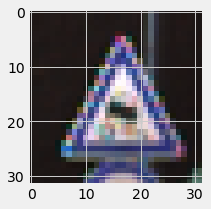

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ajout des perturbations


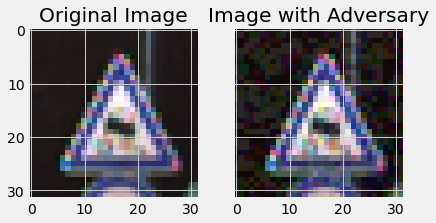

Accuracy
Normal Image Prediction: Route glissante
Adversary Prediction: Route cahoteuse
3536
Prediction from CNN:Cédez le passage


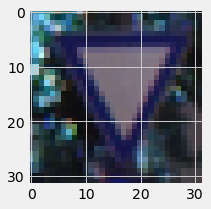

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ajout des perturbations


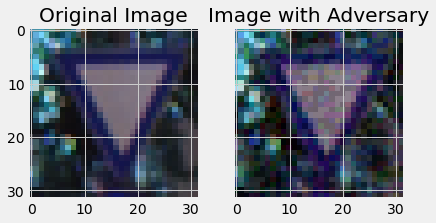

Accuracy
Normal Image Prediction: Cédez le passage
Adversary Prediction: Pas de véhicules


In [31]:
image_test,label_test = affiche_fgsm(X_valvgg, y_valvgg1)
image_test,label_test = affiche_fgsm(X_trainvgg, y_trainvgg1)

In [32]:
# Function to generate batch of images with adversary
def adversary_generator(batch_size,y_train,x_train):
  while True:
    images = []
    labels = []
    #taille = len(x_train)/taille
    #print(taille)*
    
    for batch in range(batch_size):
      N = np.random.randint(0,len(y_train))
      label = y_train[N]
      image = x_train[N].reshape((1,IMG_HEIGHT, IMG_WIDTH, channels))

      perturbations = generate_adversary(image, label).numpy()
      adversarial = image + (perturbations * 0.1)

      images.append(adversarial)
      labels.append(label)

      if batch%10000 == 0:
        print(f"{batch} images generated")

    images = np.asarray(images).reshape((batch_size,IMG_HEIGHT, IMG_WIDTH, channels))
    labels = np.asarray(labels)
    yield images, labels


In [33]:
X_trainvgg = X_trainvgg.astype('float32') 
X_valvgg = X_valvgg.astype('float32') 
y_trainvgg1 = y_trainvgg1.astype('float32') 
y_valvgg1 = y_valvgg1.astype('float32')

In [34]:
    # Testing model accuracy on adversarial examples
x_adversarial_train, y_adversarial_train = next(adversary_generator(len(X_trainvgg),y_trainvgg1,X_trainvgg))
ad_acc = modele20c.evaluate(x_adversarial_train, y_adversarial_train, verbose=0)
print(f"Accuracy on Adversarial Examples: {ad_acc[1]*100}")

0 images generated
10000 images generated
20000 images generated
Accuracy on Adversarial Examples: 4.0078699588775635


In [35]:
    # Testing model accuracy on adversarial examples
x_adversarial_test, y_adversarial_test = next(adversary_generator(len(y_valvgg1),y_valvgg1,X_valvgg))
ad_acc = modele20c.evaluate(x_adversarial_test, y_adversarial_test, verbose=0)
print(f"Accuracy on Adversarial Examples: {ad_acc[1]*100}")

0 images generated
10000 images generated
Accuracy on Adversarial Examples: 4.599167034029961


In [36]:
print(f'x_adversarial-shape={x_adversarial_test.shape}')
print(f'y_adversarial-shape={y_adversarial_test.shape}')
print(f'x_adversarial-shape={x_adversarial_train.shape}')
print(f'y_adversarial-shape={y_adversarial_train.shape}')


x_adversarial-shape=(11763, 32, 32, 3)
y_adversarial-shape=(11763, 43)
x_adversarial-shape=(27446, 32, 32, 3)
y_adversarial-shape=(27446, 43)


###### entrainement contradictoire sur FGSM 

Epoch 1/10
858/858 [==============================] - 36s 41ms/step - loss: 1.5340 - accuracy: 0.5941 - val_loss: 0.3246 - val_accuracy: 0.9077
Epoch 2/10
858/858 [==============================] - 38s 45ms/step - loss: 0.5573 - accuracy: 0.8324 - val_loss: 0.2510 - val_accuracy: 0.9249
Epoch 3/10
858/858 [==============================] - 40s 47ms/step - loss: 0.3652 - accuracy: 0.8894 - val_loss: 0.1708 - val_accuracy: 0.9495
Epoch 4/10
858/858 [==============================] - 38s 44ms/step - loss: 0.2684 - accuracy: 0.9184 - val_loss: 0.1116 - val_accuracy: 0.9654
Epoch 5/10
858/858 [==============================] - 37s 43ms/step - loss: 0.2115 - accuracy: 0.9346 - val_loss: 0.0900 - val_accuracy: 0.9716
Epoch 6/10
858/858 [==============================] - 37s 44ms/step - loss: 0.1792 - accuracy: 0.9453 - val_loss: 0.1391 - val_accuracy: 0.9562
Epoch 7/10
858/858 [==============================] - 37s 43ms/step - loss: 0.1536 - accuracy: 0.9521 - val_loss: 0.0933 - val_accuracy:

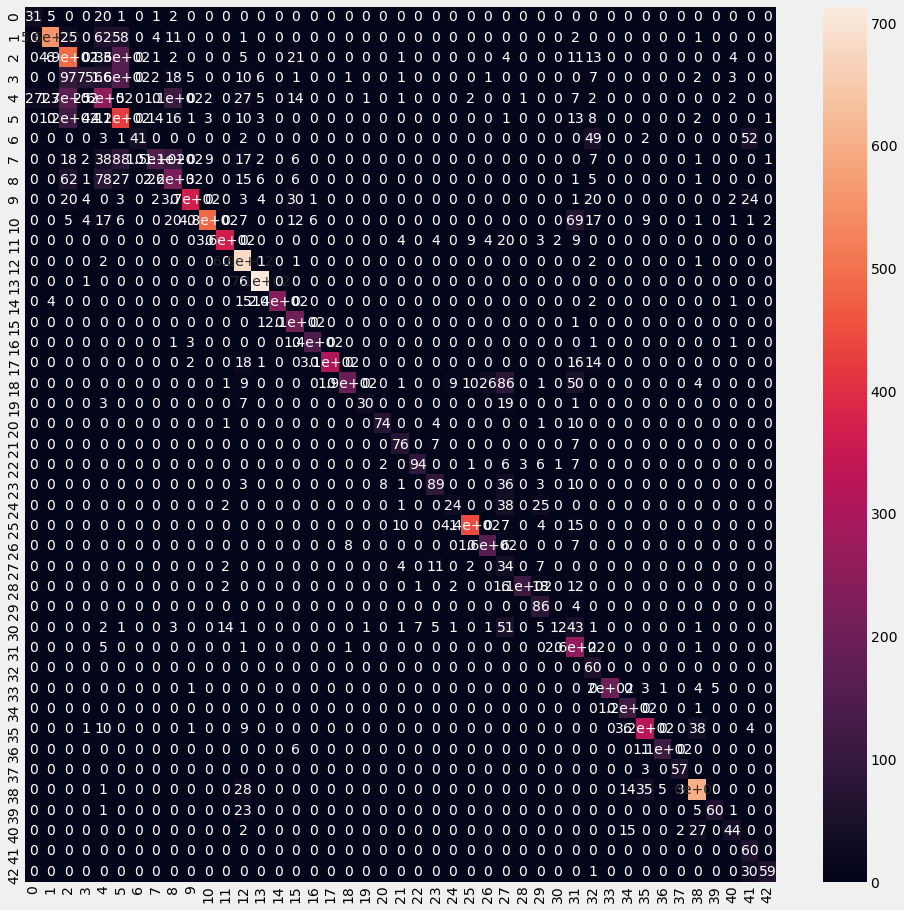

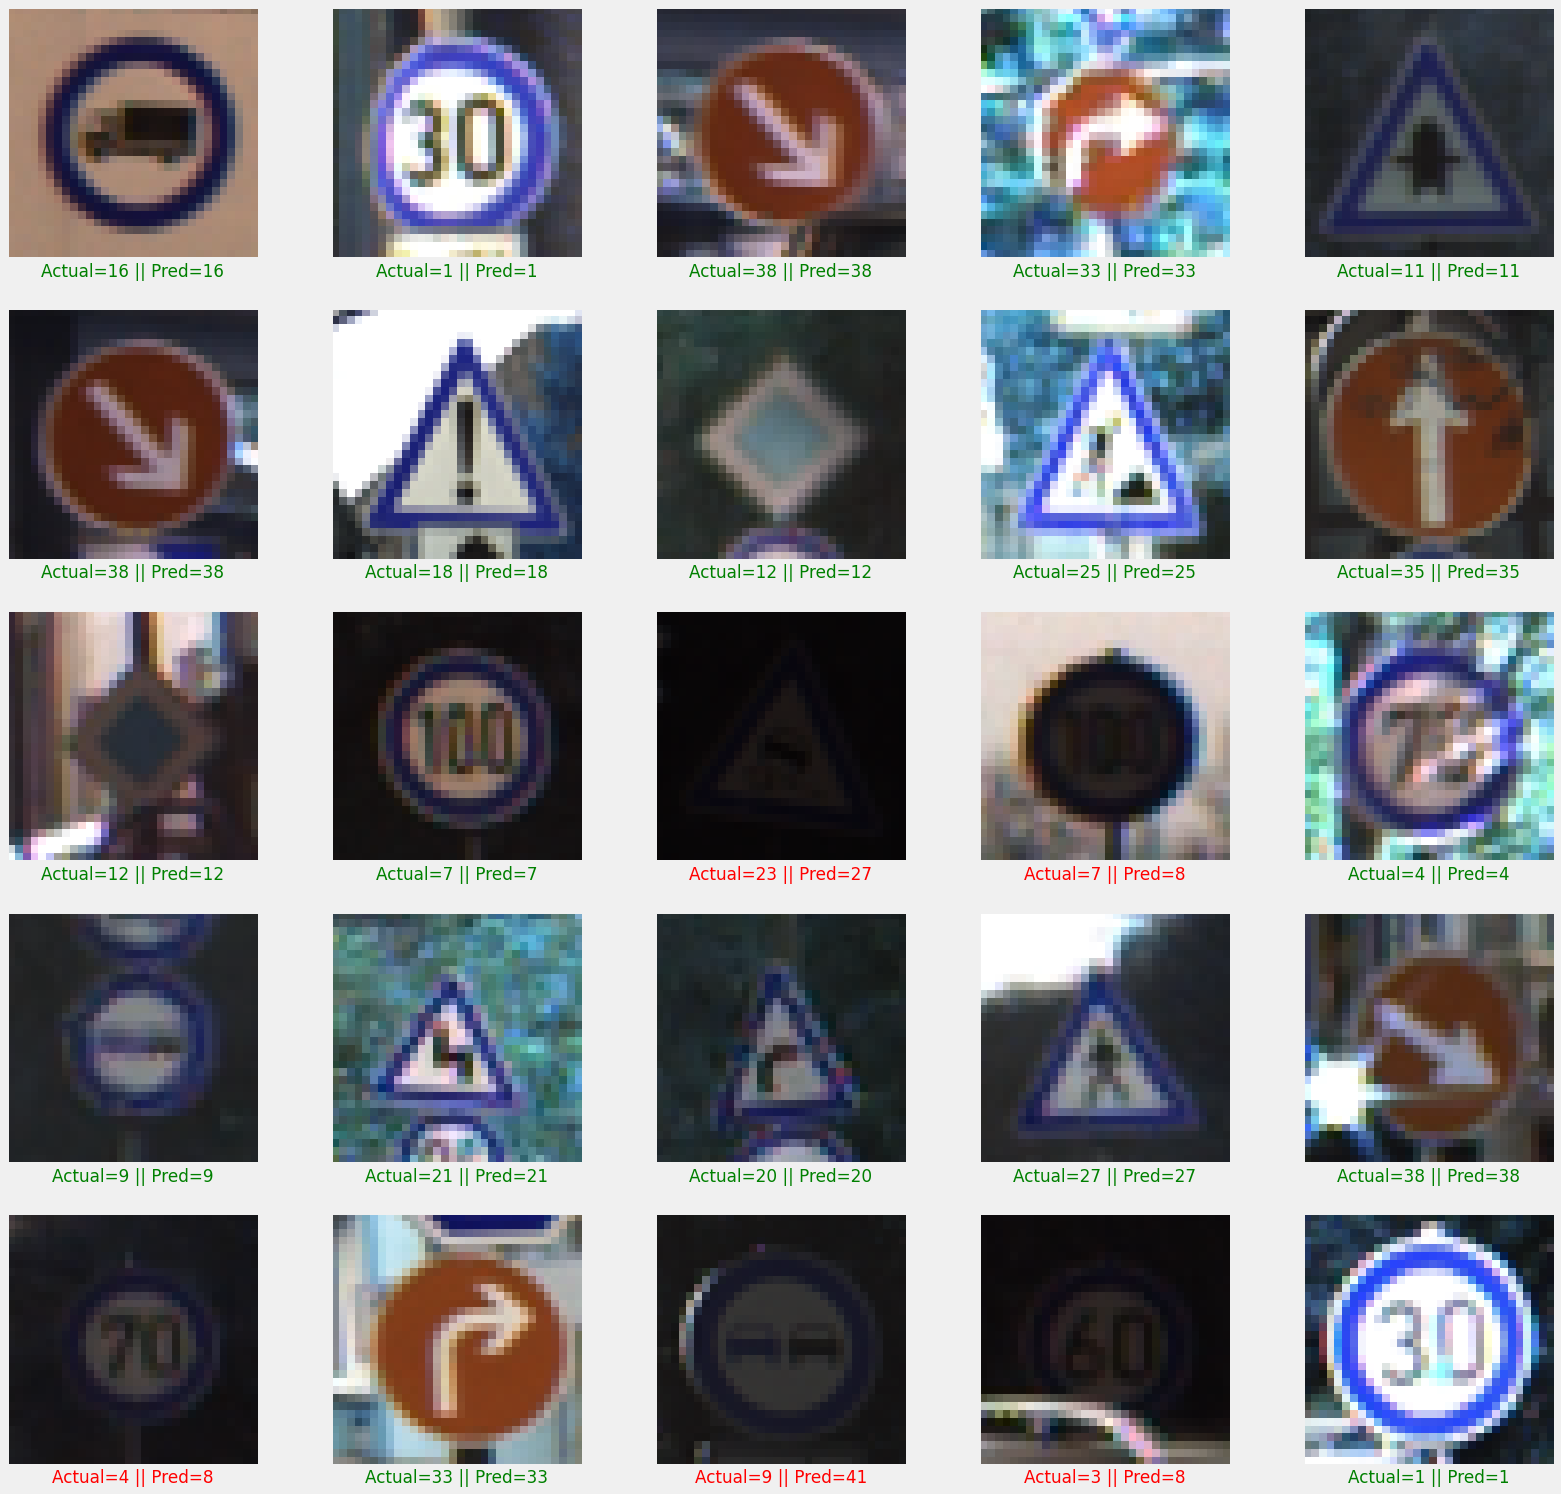

In [99]:
#entrainement contradictoire
modele20cfgsm =model1(IMG_HEIGHT , IMG_WIDTH, channels)
nombre_iteration = 10

mode11gsm = mode(modele20cfgsm ,x_adversarial_train,y_adversarial_train, x_adversarial_test, y_adversarial_test ,nombre_iteration)
pred, labels,Test_Data_accuracy,X_test = prediction (modele20cfgsm ,IMG_HEIGHT , IMG_WIDTH)
affiche_pred(pred,labels)

###### Autoencoder  sur FGSM 

In [44]:
#model_20_autoencodeur_fgsm=AutoEncdoer(input_shape)
model_detector_fgsm,model_reformer_fgsm=att()
entrainement_autoencodeur(x_adversarial_train,X_trainvgg,x_adversarial_test, X_valvgg,
                         model_detector_fgsm,model_reformer_fgsm)


Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 3)         84        
_________________________________________________________________
activation_3 (Activation)    (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 3)         84        
_________________________________________________________________
activation_4 (Activation)    (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 3)         84        
_________________________________________________________________
activation_5 (Activation)    (None, 32, 32, 3)        

<ipython-input-41-22d7e6623248>:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.vstack(hstackimgs(i*length, (i+1)*length, images) for i in range(height))
<ipython-input-41-22d7e6623248>:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.hstack(images[i] for i in range(min, max))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


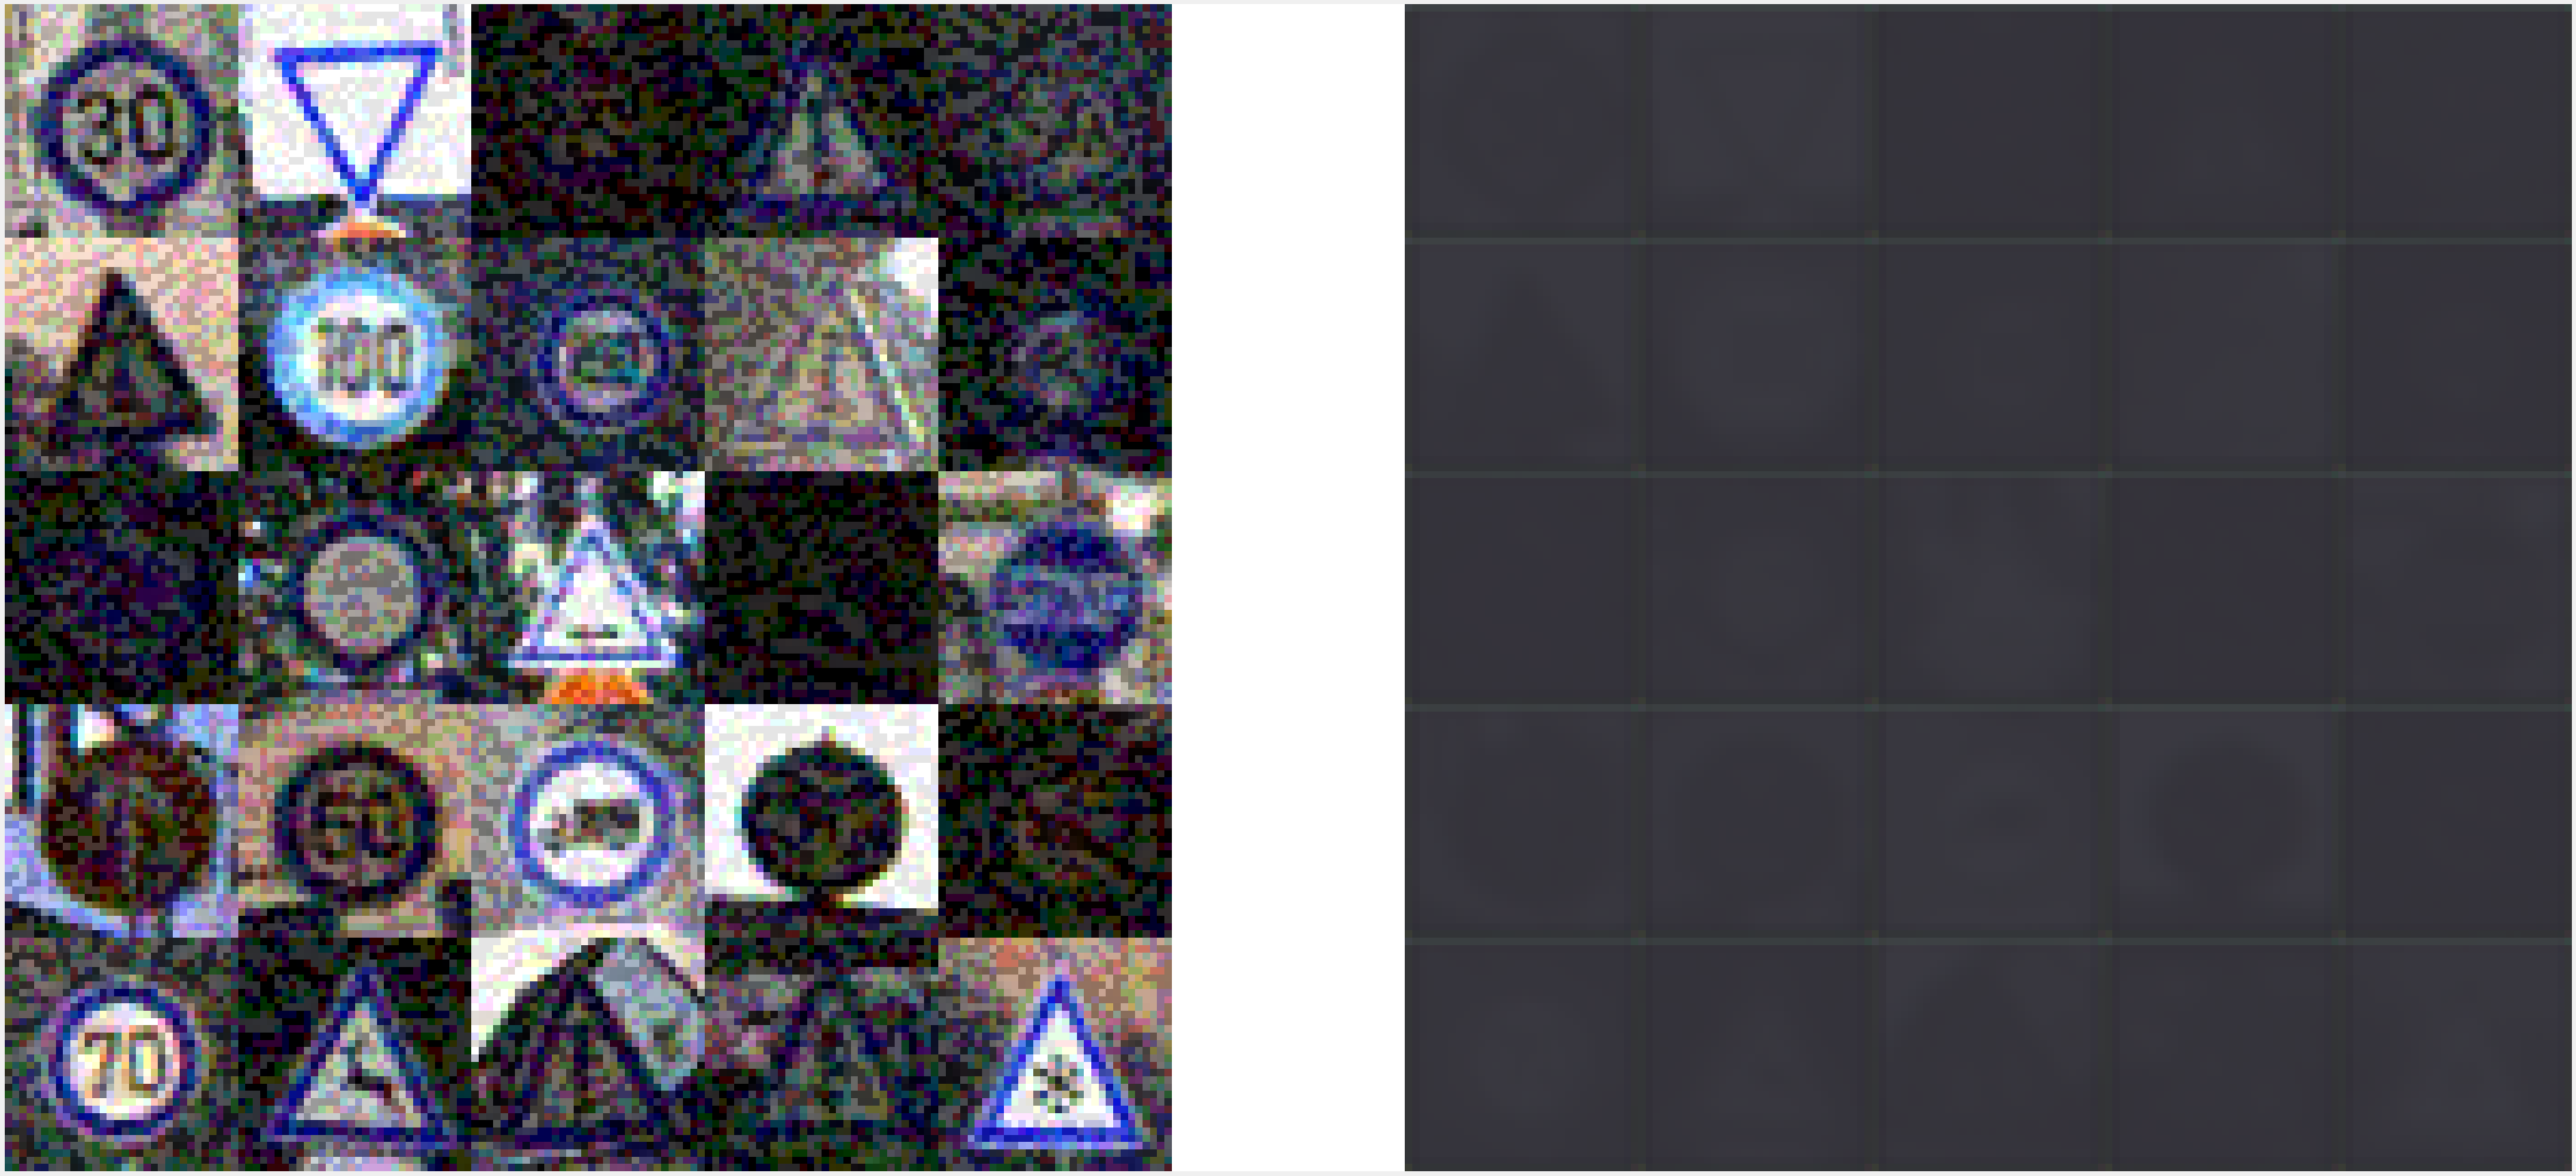

In [72]:
#affiche_autoencoder(x_test_patch,model_20_autoencodeur_patch)
resultat_fgsm = prediction_autoencodeur(x_adversarial_test,model_detector_fgsm)

Test Data accuracy:  5.644818498682309


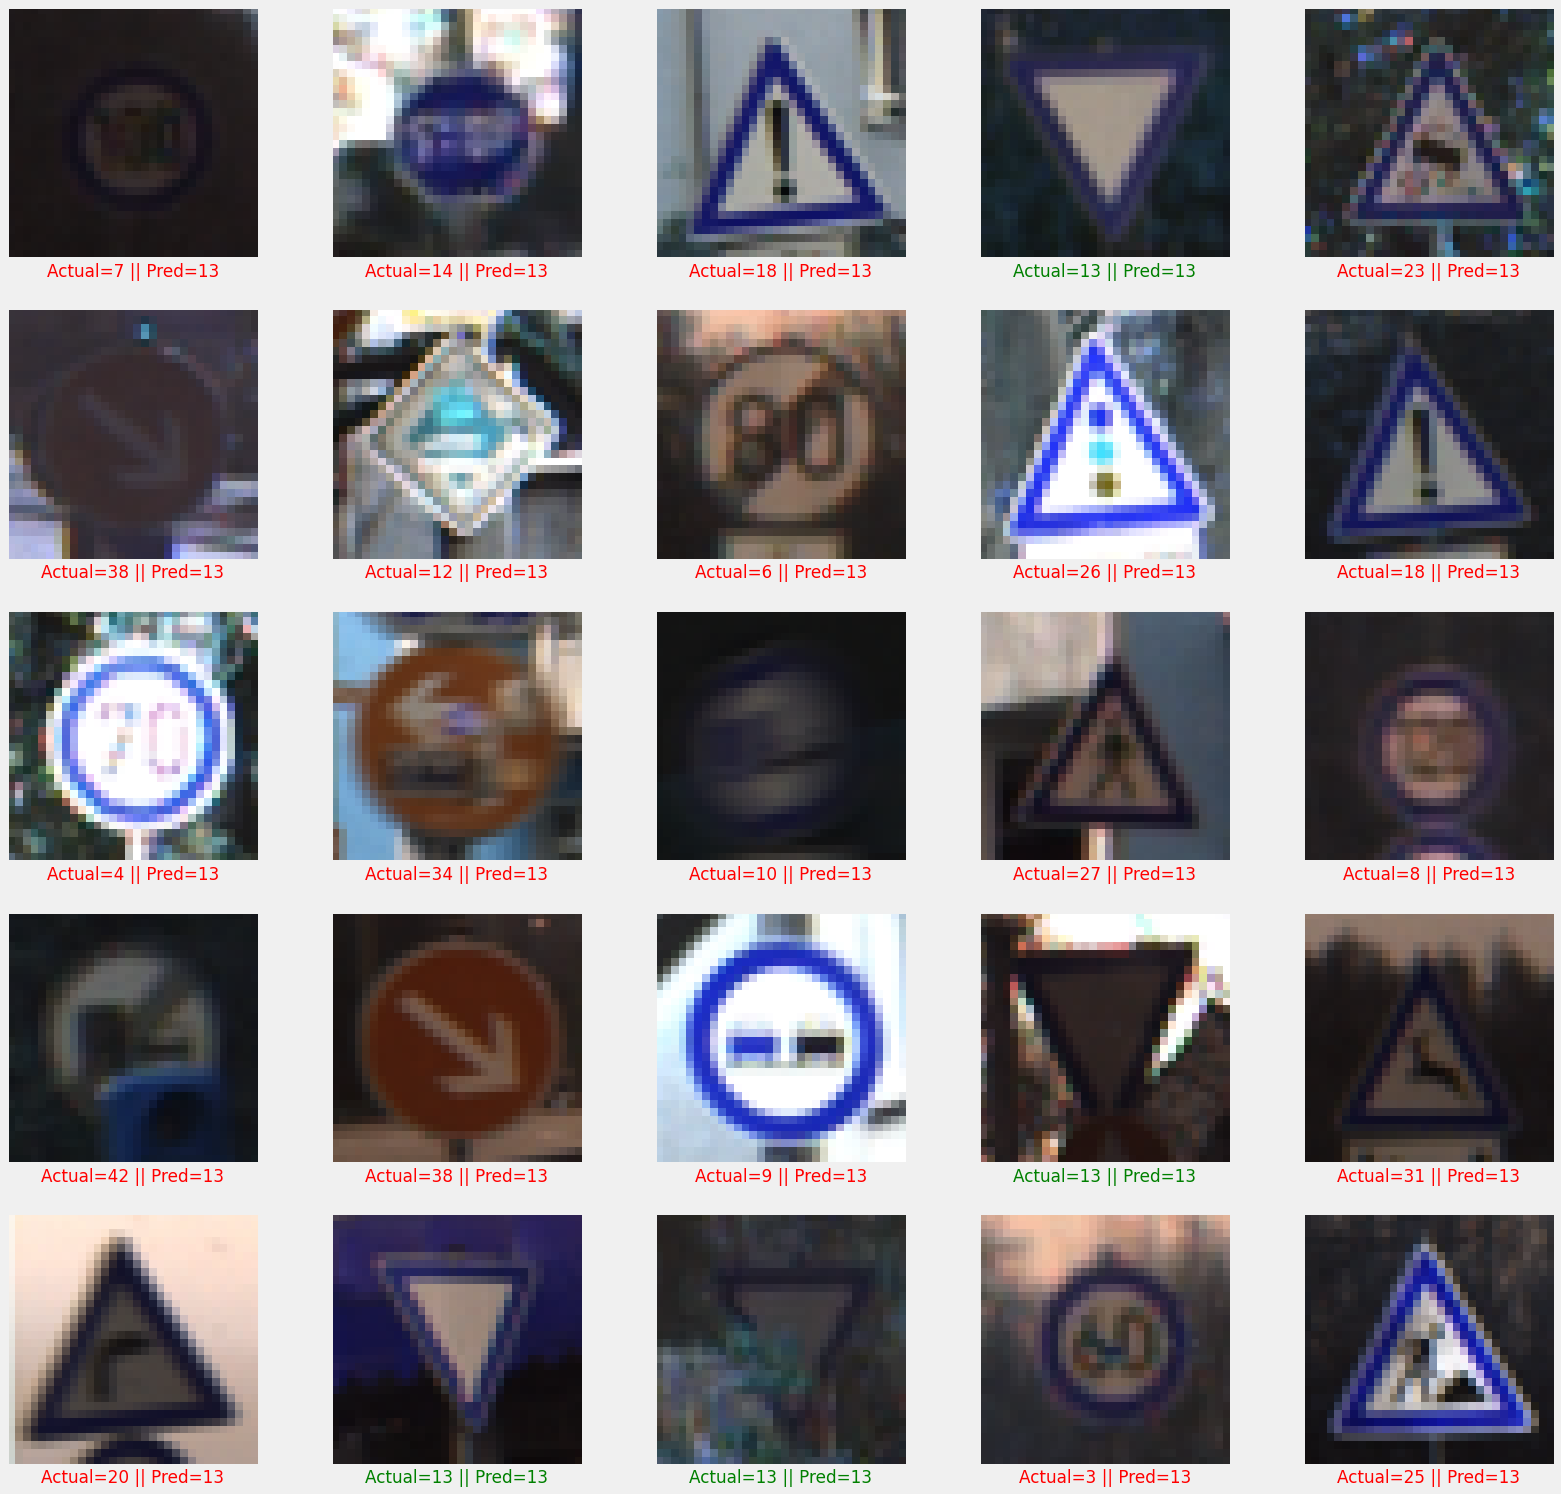

In [83]:
##prediction sur des image deruités par l'autoencoder
printresultat(resultat_fgsm)
#affiche_autoencoder(x_adversarial_test,modele20c)

###### KNN sur FGSM

In [39]:
'''x_adversarial_trainknn, y_adversarial_trainknn = transformation_knn(x_adversarial_train,
                                                                    y_adversarial_train)

x_adversarial_testknn, y_adversarial_testknn = transformation_knn(x_adversarial_test,
                                                                    y_adversarial_test)'''

In [40]:
'''y_pred_knn_fgsm , model= knn_prediction(x_adversarial_trainknn, y_adversarial_trainknn,
                                 x_adversarial_testknn, y_adversarial_testknn)'''

0.8496982062399048


In [43]:
'''chiffre = 20
print(metrics.accuracy_score(y_pred_knn_fgsm, y_adversarial_test)) 
#print(classification_report(y_adversarial_test, y_pred_knn_fgsm))
verificatio_pred(y_pred_knn_fgsm,y_valvgg,chiffre)'''

0.8496982062399048
original:  7  predicted:  1 nom pannaux:  Limite de vitesse (100km/h)
original:  14  predicted:  13 nom pannaux:  Arrêt
original:  18  predicted:  2 nom pannaux:  Attention générale
original:  13  predicted:  28 nom pannaux:  Cédez le passage
original:  23  predicted:  5 nom pannaux:  Route glissante
original:  38  predicted:  18 nom pannaux:  Garder la droite
original:  12  predicted:  7 nom pannaux:  Route prioritaire
original:  6  predicted:  7 nom pannaux:  Fin de la limite de vitesse (80km/h)
original:  26  predicted:  18 nom pannaux:  Signaux de circulation
original:  18  predicted:  7 nom pannaux:  Attention générale
original:  4  predicted:  12 nom pannaux:  Vitesse limite (70km/h)
original:  34  predicted:  5 nom pannaux:  Tourner à gauche devant
original:  10  predicted:  22 nom pannaux:  Interdiction de dépasser les véhicules de plus de 3,5 tonnes
original:  27  predicted:  18 nom pannaux:  Piétons
original:  8  predicted:  5 nom pannaux:  Limite de vitess

(43,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Vitesse limite  (20km/h)


array([[[  0.18039216,   0.19607843,   0.19607843],
        [  0.1764706 ,   0.19607843,   0.20784314],
        [  0.16862746,   0.19607843,   0.21960784],
        ...,
        [  0.20392157,   0.23137255,   0.2509804 ],
        [  0.18431373,   0.21176471,   0.22352941],
        [  0.1764706 ,   0.2       ,   0.20784314]],

       [[  0.18431373,   0.2       ,   0.2       ],
        [  0.18431373,   0.20784314,   0.21960784],
        [  0.18039216,   0.21568628,   0.23921569],
        ...,
        [  0.19607843,   0.23137255,   0.25882354],
        [  0.18039216,   0.21960784,   0.23921569],
        [  0.16470589,   0.19607843,   0.20392157]],

       [[  0.19607843,   0.21176471,   0.21568628],
        [  0.1764706 ,   0.19607843,   0.21176471],
        [  0.16862746,   0.2       ,   0.23529412],
        ...,
        [  0.2       ,   0.23137255,   0.26666668],
        [  0.19215687,   0.23137255,   0.2509804 ],
        [  0.16862746,   0.19607843,   0.20784314]],

       ...,

      

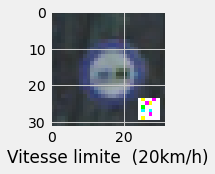

In [108]:
'''def plotter(X,y,index):
    plt.figure(figsize=(10,2))
    print(classes_dict[np.argmax(y[index])])
    plt.imshow(X[index])
    plt.xlabel(classes_dict[np.argmax(y[index])])
    return X[index] 
plotter(x_train_patch,y_trainvgg,5)'''

#### Générateur de perturbations aléatoires (black box attack)


In [55]:
def gen_perturbations_show(img,label,eps,maxpert):
  fiximg = img
 
  pred = np.argmax(modele20c.predict((img), batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False),axis =1 )[0]
  #print(classes_dict[pred])
  #print(pred)
  
  
  #rand_pert = np.random.randint(-1,2,size=[32,32,3])*eps
  rand_pert = np.random.normal(0,1,size=[32,32,3])*eps
  new_img = img + rand_pert
  #tablepred  = modele20c.predict(new_img, batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)
  #pred = np.argmax(tablepred,axis =1 )[0]
   
  return new_img

In [66]:
random_test_attack = gen_perturbations_show((X_valvgg),y_valvgg,0.30,3)

In [67]:
random_train_attack = gen_perturbations_show((X_trainvgg),y_trainvgg,0.30,3)

#### autoencoder blackbox

In [68]:
model_detector_random,model_reformer_random=att()
entrainement_autoencodeur(random_train_attack,X_trainvgg,random_test_attack, X_valvgg,
                         model_detector_random,model_reformer_random)


Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 3)         84        
_________________________________________________________________
activation_9 (Activation)    (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 3)         84        
_________________________________________________________________
activation_10 (Activation)   (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 3)         84        
_________________________________________________________________
activation_11 (Activation)   (None, 32, 32, 3)       

<ipython-input-41-22d7e6623248>:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.vstack(hstackimgs(i*length, (i+1)*length, images) for i in range(height))
<ipython-input-41-22d7e6623248>:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.hstack(images[i] for i in range(min, max))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


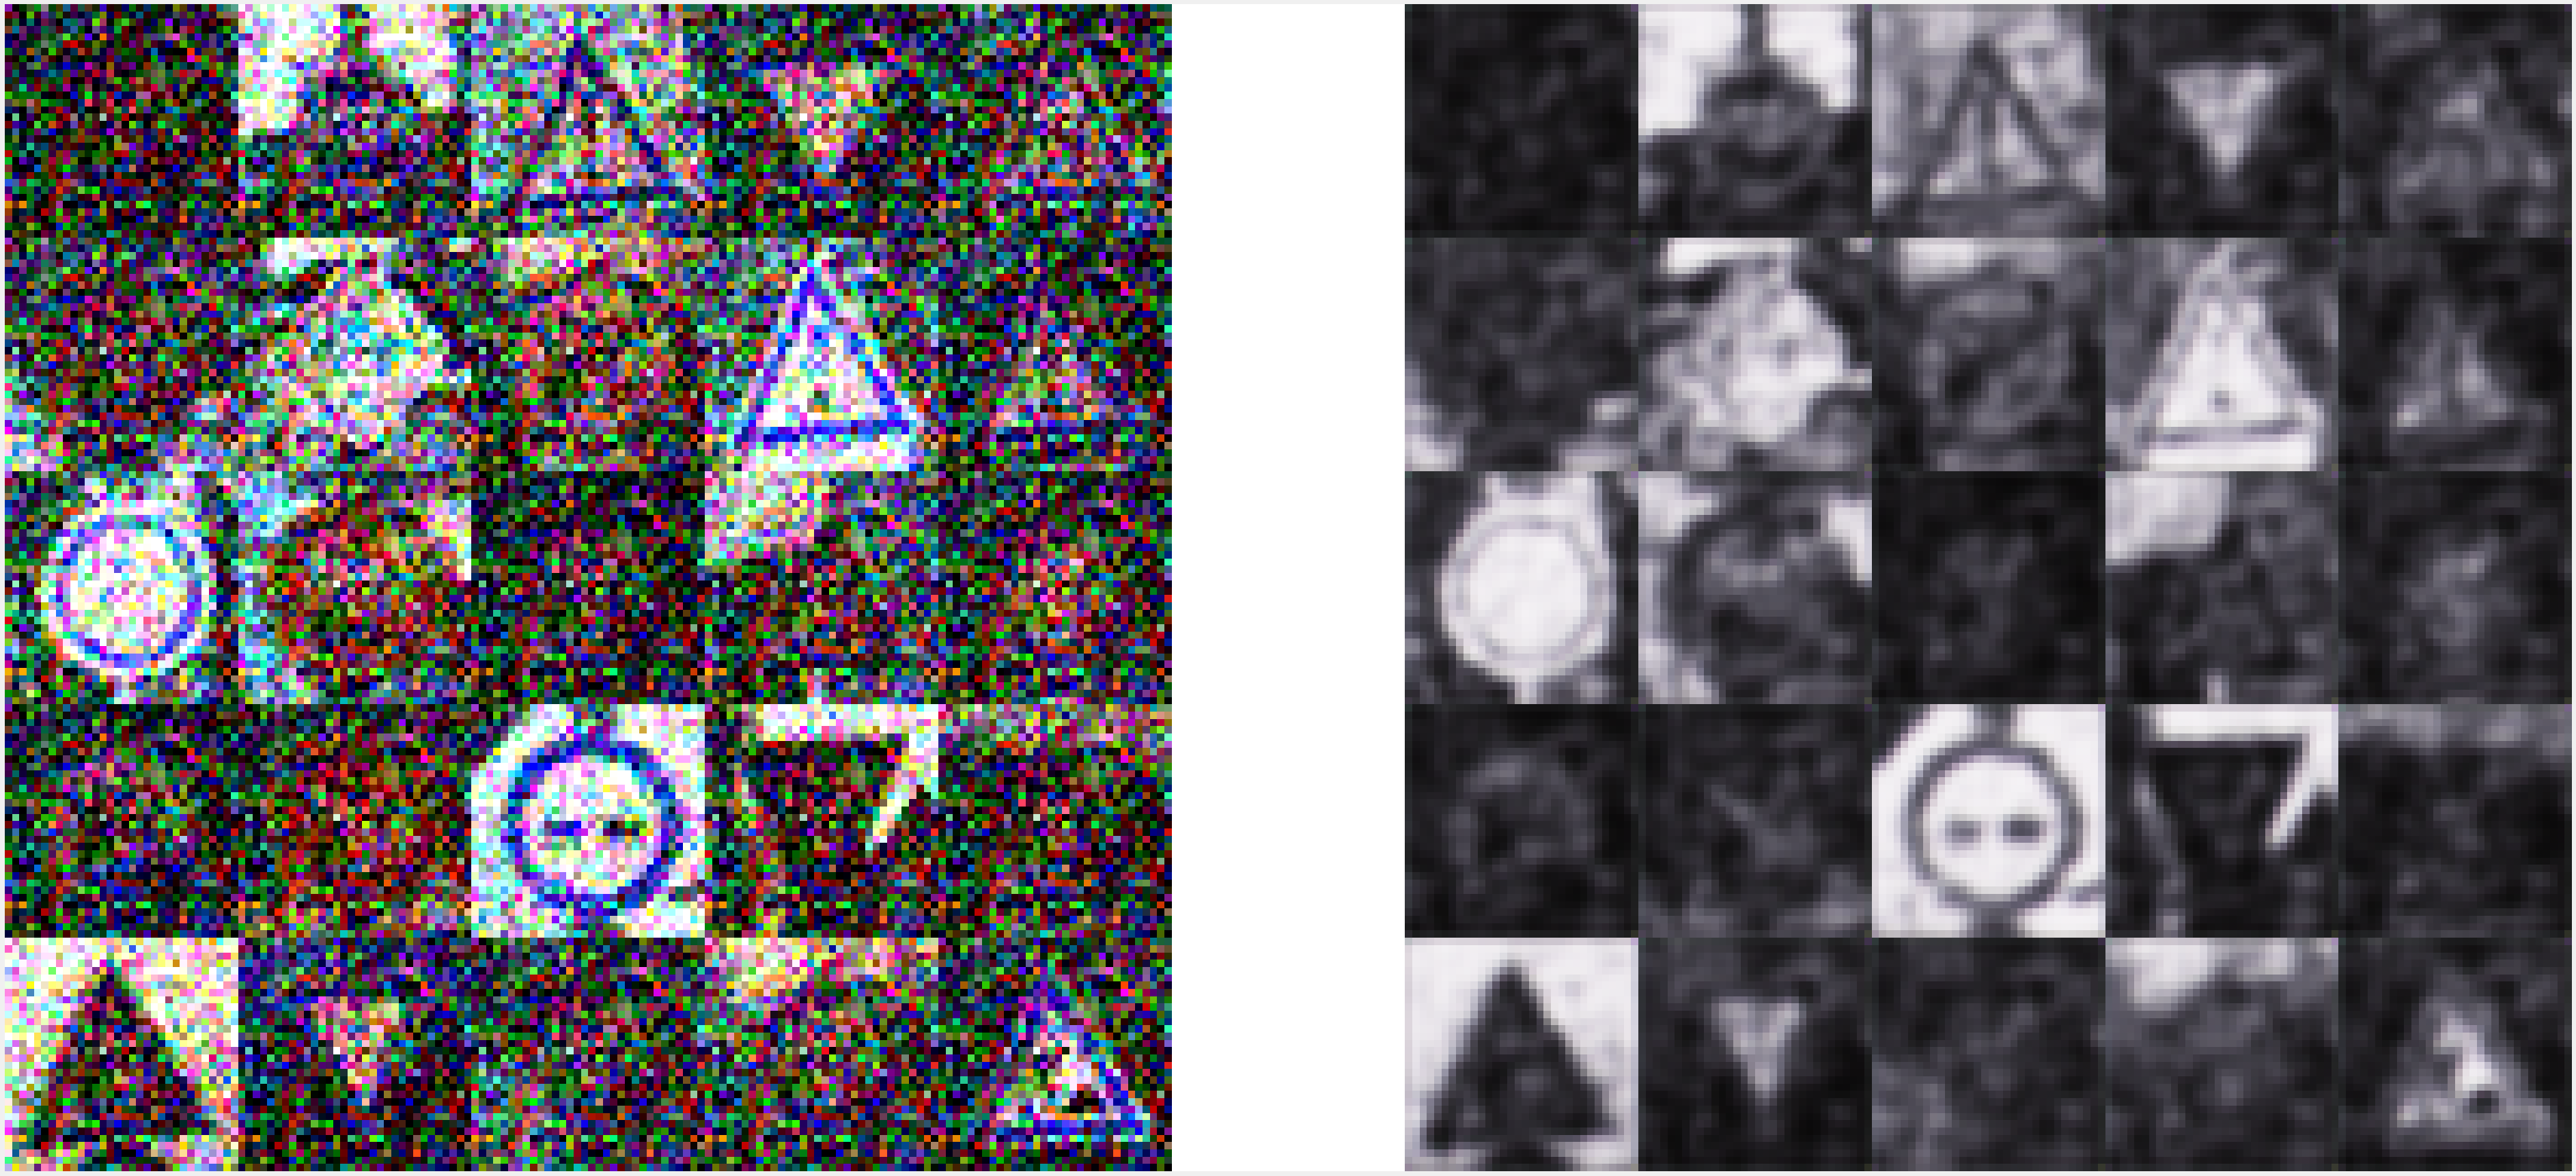

In [77]:
resultat_random = prediction_autoencodeur(random_test_attack,model_detector_random)

Test Data accuracy:  41.213976026523845


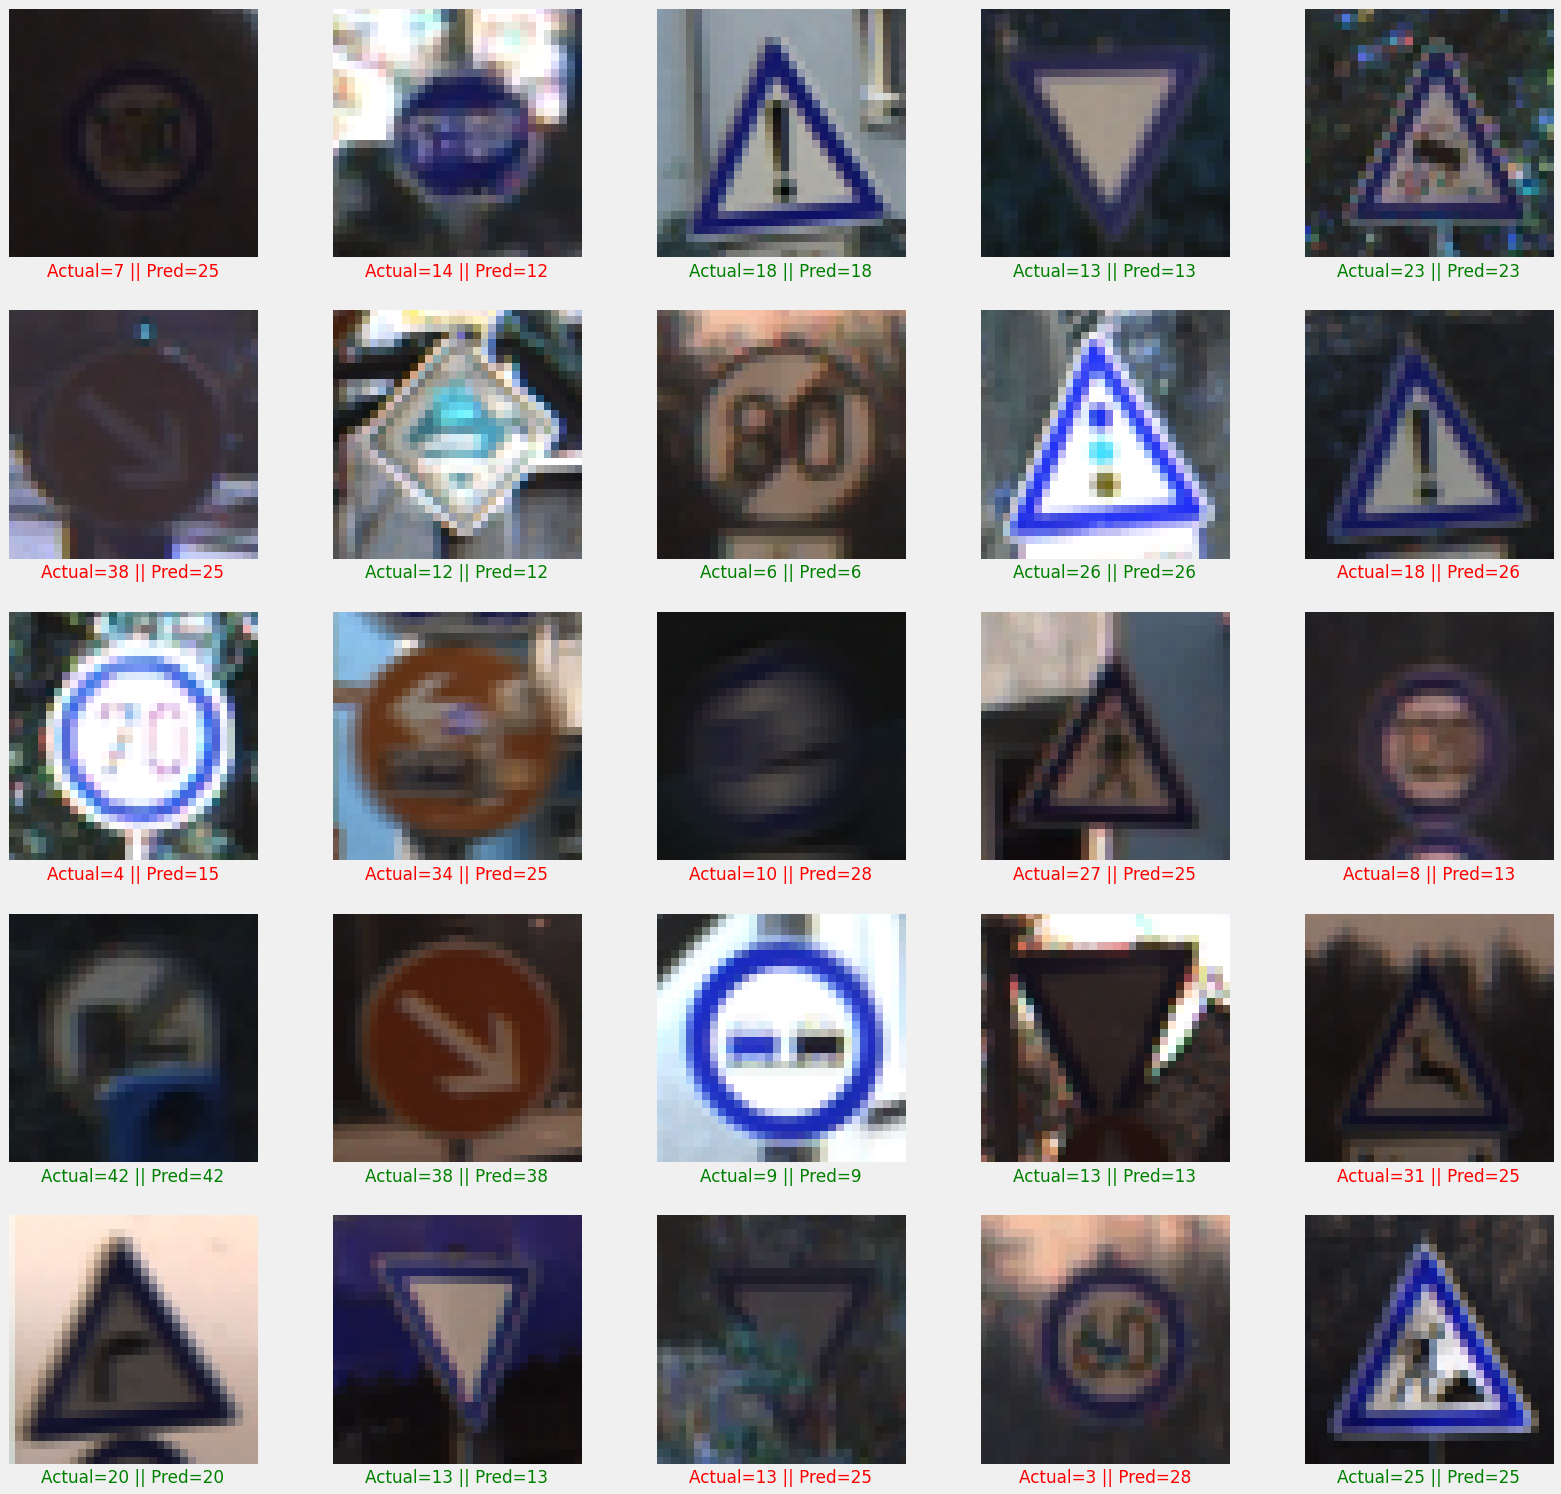

In [82]:
printresultat(resultat_random)

#### adversarial training

Epoch 1/10
858/858 [==============================] - 35s 40ms/step - loss: 1.5972 - accuracy: 0.5714 - val_loss: 2.1214 - val_accuracy: 0.4177
Epoch 2/10
858/858 [==============================] - 35s 40ms/step - loss: 0.4391 - accuracy: 0.8629 - val_loss: 2.1356 - val_accuracy: 0.4663
Epoch 3/10
858/858 [==============================] - 35s 41ms/step - loss: 0.2657 - accuracy: 0.9175 - val_loss: 2.3154 - val_accuracy: 0.4432
Epoch 4/10
858/858 [==============================] - 35s 41ms/step - loss: 0.2009 - accuracy: 0.9383 - val_loss: 2.5528 - val_accuracy: 0.4195
Epoch 5/10
858/858 [==============================] - 36s 42ms/step - loss: 0.1648 - accuracy: 0.9479 - val_loss: 2.1443 - val_accuracy: 0.4986
Epoch 6/10
858/858 [==============================] - 35s 41ms/step - loss: 0.1414 - accuracy: 0.9572 - val_loss: 1.9936 - val_accuracy: 0.5400
Epoch 7/10
858/858 [==============================] - 35s 41ms/step - loss: 0.1188 - accuracy: 0.9639 - val_loss: 2.2131 - val_accuracy:

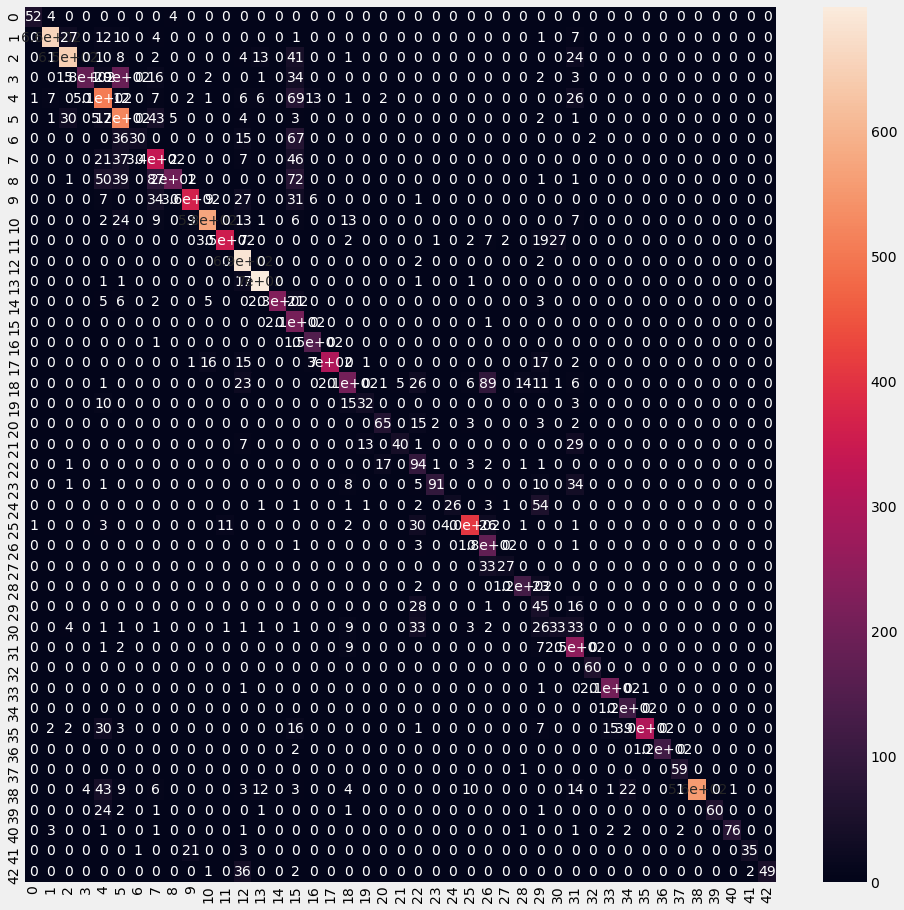

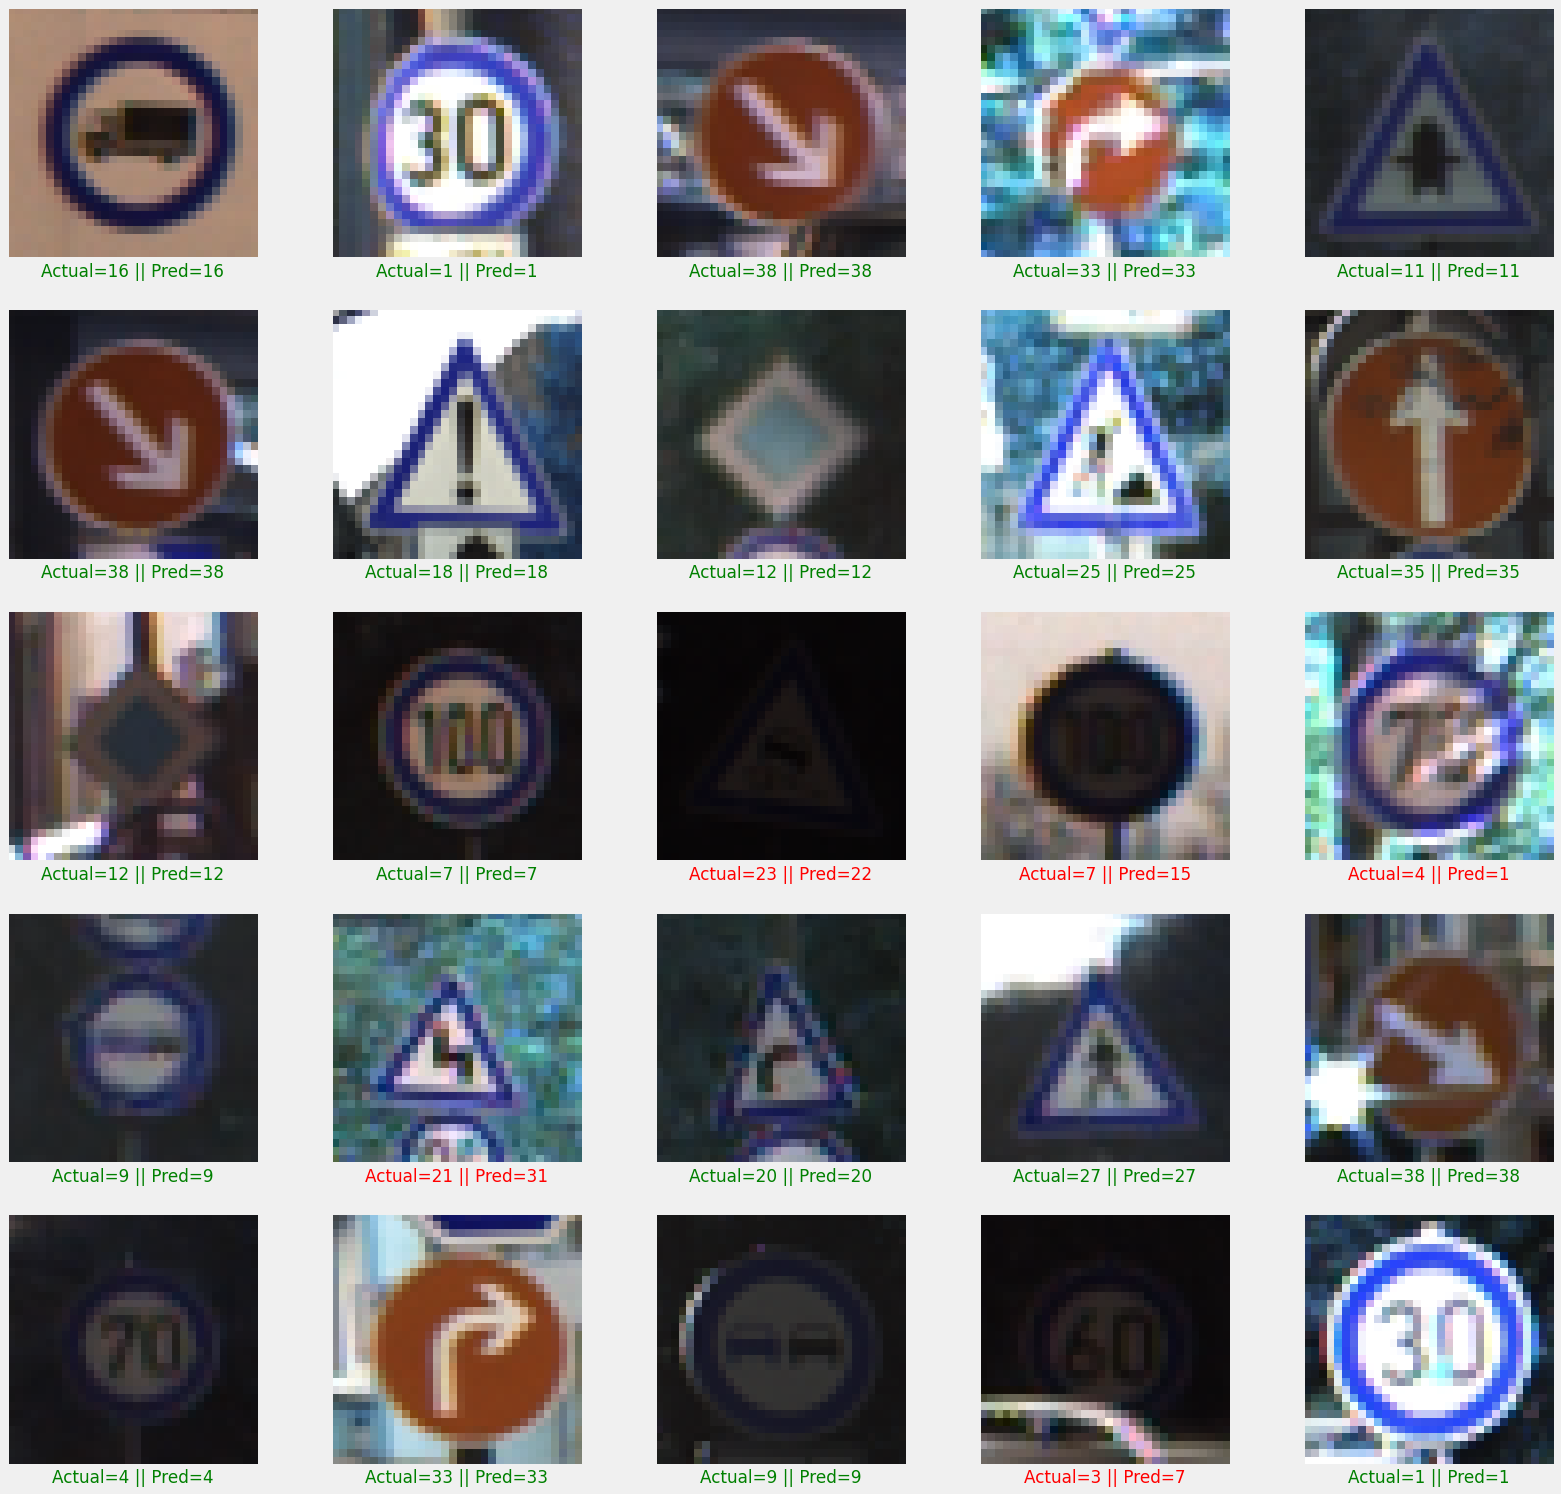

In [98]:
#entrainement contradictoire
modele20crandom =model1(IMG_HEIGHT , IMG_WIDTH, channels)
nombre_iteration = 10

mode11random = mode(modele20crandom ,random_train_attack,y_trainvgg1, random_test_attack, y_valvgg1 ,nombre_iteration)
pred_random, labels_random,Test_Data_accuracy_random,X_test_random = prediction (modele20crandom ,
                                                                    IMG_HEIGHT , IMG_WIDTH)
affiche_pred(pred_random, labels_random)

In [85]:
print(random_train_attack.shape,y_trainvgg.shape, random_test_attack.shape, y_valvgg.shape)

(27446, 32, 32, 3) (27446,) (11763, 32, 32, 3) (11763,)
